### 3DDPD tutorial

In this tutorial you will learn to:
1. Inspect publicly available Molecular Dynamics (MD) trajectories from the [GPCRmd](https://submission.gpcrmd.org/home/) database
2. Generate 3D dynamic protein descriptors (3DDPDs) for the trajectories of interest

We start by importing all the necessary dependencies and setting up the data directories.

In [4]:
import os
import pandas as pd
from pathlib import Path
import requests
from src.md_3ddpd import MD_analysis,StructBindingPocket,DynDescriptor

In [5]:
# Set path to this notebook
HERE = Path(_dh[-1])
# Set path to tutorial data directory
DATA = HERE / 'tutorial_data'
# Set path to repo data directory
data = HERE.parent.absolute() / 'data'

In [6]:
# Define path to sample GPCRmd trajectories
gpcrmd_path = DATA / 'input' / 'GPCRmd'
# Define path to output
out_path = DATA / 'output'
# Define multiple sequence alignment file
msa_file = data / '3ddpd_MSA.json'
# Define binding pocket definition file
bp_file = data / '3ddpd_BP.json'

#### GPCRmd trajectory exploration

For this tutorial, we are going to download the MD data directly from GPCRmd for three GPCRs and store it on the
input folder. For each target, we create a subfolder within /input with the protein's Uniprot name (e.g. /aa1r_human,
/aa2ar_human, /ccr5_human). Several trajectories from different PDBs are available for some GPCRs on the database. In
 this case, we choose apo structures (i.e. with no co-crystalized ligand) in its inactive conformation, as follows:

| Uniprot name | PDB code | GPCRmd ID | Replicate 1 ID | Topology ID |
|--------------|----------|-----------|----------------|-------------|
| aa1r_human   | 5UEN     | 165       | 11532          | 11536       |
| aa2ar_human  | 5IU4     | 49        | 10504          | 10509       |
| ccr5_human   | 4MBS     | 118       | 11127          | 11148       |

We first define a helper function to downlaod and rename the files from GPCRmd:

In [ ]:
# Download MD coordinate files and trajectories
def download_gpcrmd_files(uniprot_name, gpcrmd_dict):
    """
    Create a subdirectory for each uniprot name and download in it the corresponding files from GPCRmd.
    :param uniprot_name: Uniprot code for the protein of interest.
    :param gpcrmd_dict: Dictionary with the gpcrmd, trajectory, and topology file IDs for the protein of interest.
    """
    # Make directory
    if not os.path.exists(os.path.join(gpcrmd_path, uniprot_name)):
        os.mkdir(os.path.join(gpcrmd_path, uniprot_name))

    # Specify url of data to download
    url_traj = f'https://submission.gpcrmd.org/dynadb/files/Dynamics/{gpcrmd_dict["traj_id"]}_trj_' \
               f'{gpcrmd_dict["gpcrmd_id"]}.xtc'
    traj_name = f'{gpcrmd_dict["gpcrmd_id"]}_{uniprot_name.split("_")[0]}_wt_1.xtc'
    url_top = f'https://submission.gpcrmd.org/dynadb/files/Dynamics/{gpcrmd_dict["top_id"]}_dyn_{gpcrmd_dict["gpcrmd_id"]}.psf'
    top_name = f'{gpcrmd_dict["gpcrmd_id"]}_{uniprot_name.split("_")[0]}_wt.psf'

    # Download data to target directory
    for url,name in zip([url_traj,url_top],[traj_name,top_name]):
        r = requests.get(url)
        file_name = os.path.join(gpcrmd_path, uniprot_name, name)

        with open(file_name,'wb') as f:
            f.write(r.content)

And we use the function to downlaod the data. This can take a bit (approximately 5 min per target), depending on your connection, as the trajectory files are ~ 700 MB. 

In [ ]:
tutorial_dict = {'aa1r_human': {'gpcrmd_id':165,'traj_id':11532,'top_id':11536},
                 'aa2ar_human': {'gpcrmd_id':49,'traj_id':10504,'top_id':10509},
                 'ccr5_human': {'gpcrmd_id':118,'traj_id':11127,'top_id':11148}
                }

for uniprot_name, gpcrmd_dict in tutorial_dict.items():
    download_gpcrmd_files(uniprot_name, gpcrmd_dict)

Let's also define the entries of interest for the rest of the tutorial. The ``entry`` argument is used in most of the functions and classes through the ``md_3ddpd`` package to refer to a trajectory of interest. It consists of four parts (a_b_c_d) that represent, respectively:

    a. GPCRmd ID - To reference which system was used from the GPCRmd database

    b. Uniprot target name - For easy visual recognition of the target of interest

    c. Mutant - 'wt' for wild type protein or mutant in the format 'A123C' to reference different mutants (out of the scope of this tutorial)

    d. Replicate - To reference the trajectory replicate that was used from GPCRmd. The 3 available trajectories on GPCRmd are given a number 1-3 from their lower to higher trajectory id. 

In [7]:
tutorial_entries = '165_aa1r_wt_1,49_aa2ar_wt_1,118_ccr5_wt_1'

We proceed to explore the trajectories by calculating and plotting their Root Mean Square Fluctuation (RMSF). This metric gives an idea of the rigidity of the different residues in the protein, where a higher RMSF means a more dynamic residue over the simulation. 

Normally, RMSF is plotted per residue in the protein, so we will do that first: 

Processing a list of 3 MD entries
MD trajectory read for entry 165_aa1r_wt_1
MD trajectory read for entry 49_aa2ar_wt_1
MD trajectory read for entry 118_ccr5_wt_1
RMSF calculated for entry 165_aa1r_wt_1
RMSF calculated for entry 49_aa2ar_wt_1
RMSF calculated for entry 118_ccr5_wt_1


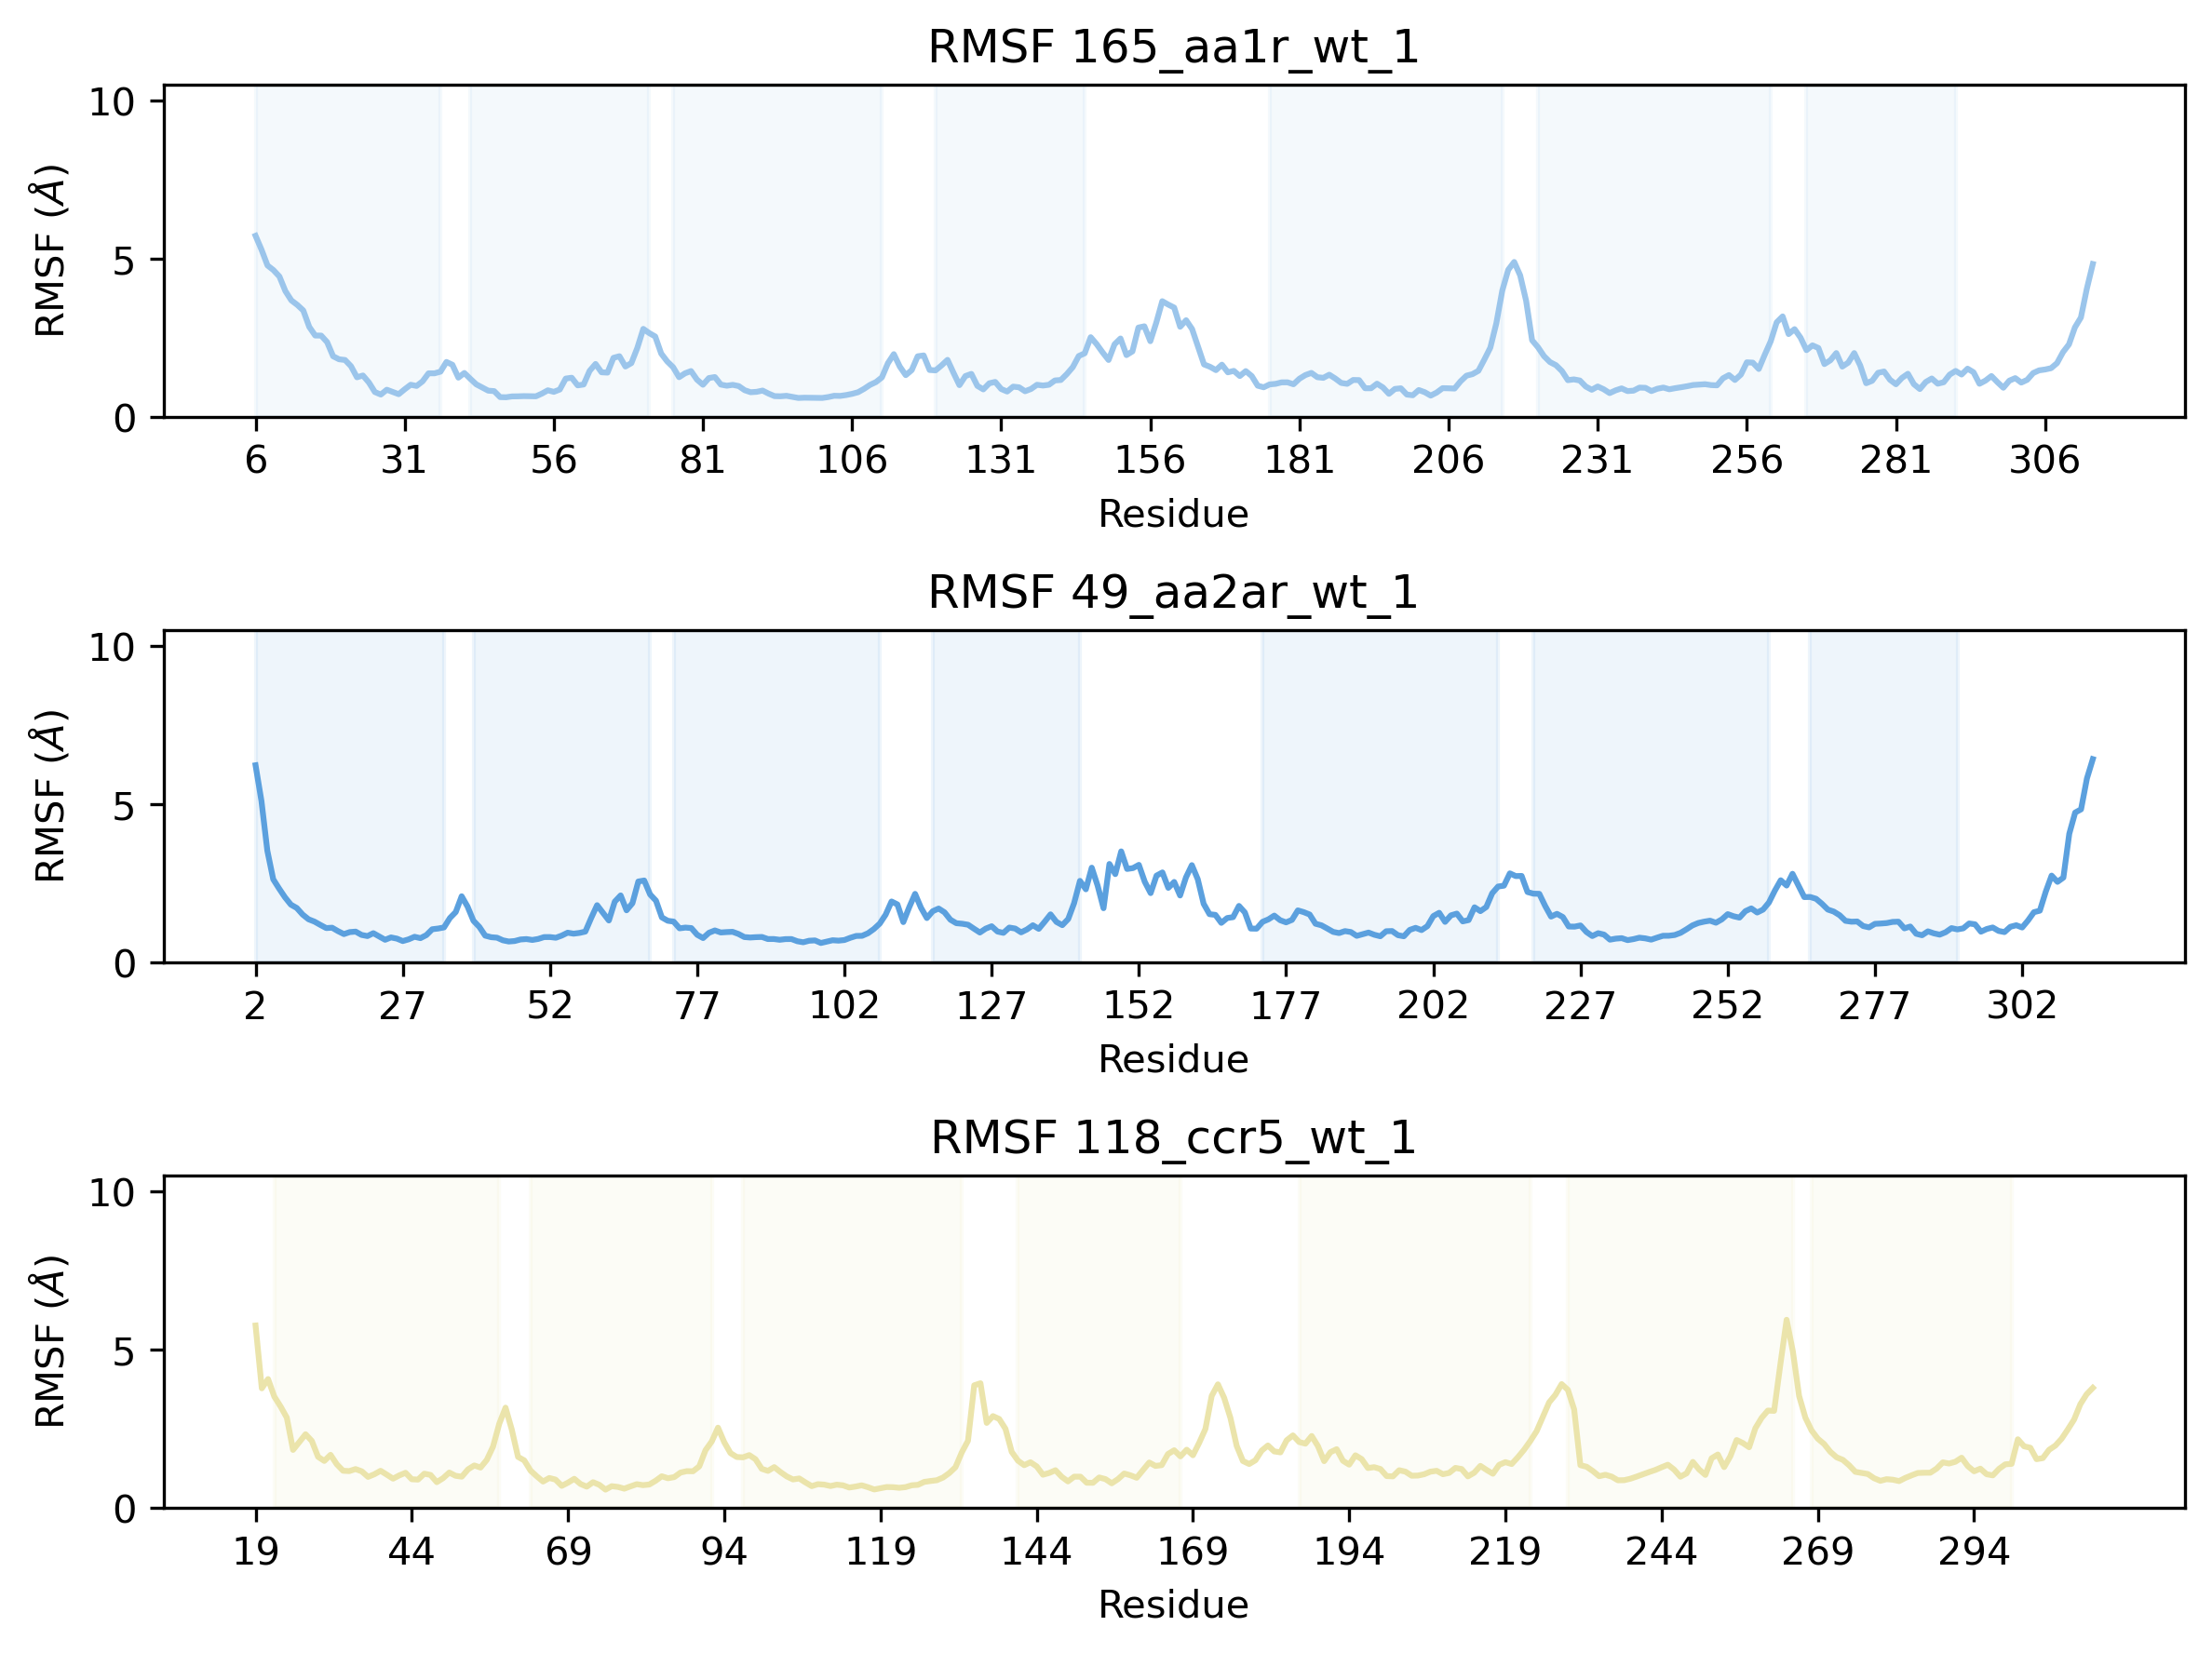

In [38]:
# Options for RMSF calculation and plotting 
md_options = {
    'normalize':False, # Relevant for mutants, to normalize respect to WT
    'save_plot':True, # Whether to save the plot
    'plot_align':False, # Whether to align RMSF to input MSA
    'plot_segments':True, # Whether to plot GPCR TM domains as segments 
    'plot_normalize':False, # Whether to plot normalized values
    'average_replicates':False, # Whether to use several replicates and their average 
    'output_dir': out_path # Path to save the plot 
}

# RMSF calculation
wt_traj = MD_analysis.MDTrajectory(gpcrmd_path,tutorial_entries,**md_options)
# RMSF plotting 
wt_traj.plot_rmsf(alias='tutorial')

However, it is difficult to compare proteins because they have different length. To solve this, we can align the RMSF values to a multiple sequence alignment (MSA) of reference for the proteins of interest, so that each position in the alignment is equivalent for each protein. For this, we use a pre-calculated GPCRbd ClassA MSA. 


**NOTE**: Check the MSA json file to understand the format of the MSA that is needed as input for RMSF alignment and 3DDPD calculation. If you want to use this package for a different protein family, you will need to pre-calculate the MSA accordingly. 

Processing a list of 3 MD entries
MD trajectory read for entry 165_aa1r_wt_1
MD trajectory read for entry 49_aa2ar_wt_1
MD trajectory read for entry 118_ccr5_wt_1
RMSF calculated for entry 165_aa1r_wt_1
RMSF calculated for entry 49_aa2ar_wt_1
RMSF calculated for entry 118_ccr5_wt_1


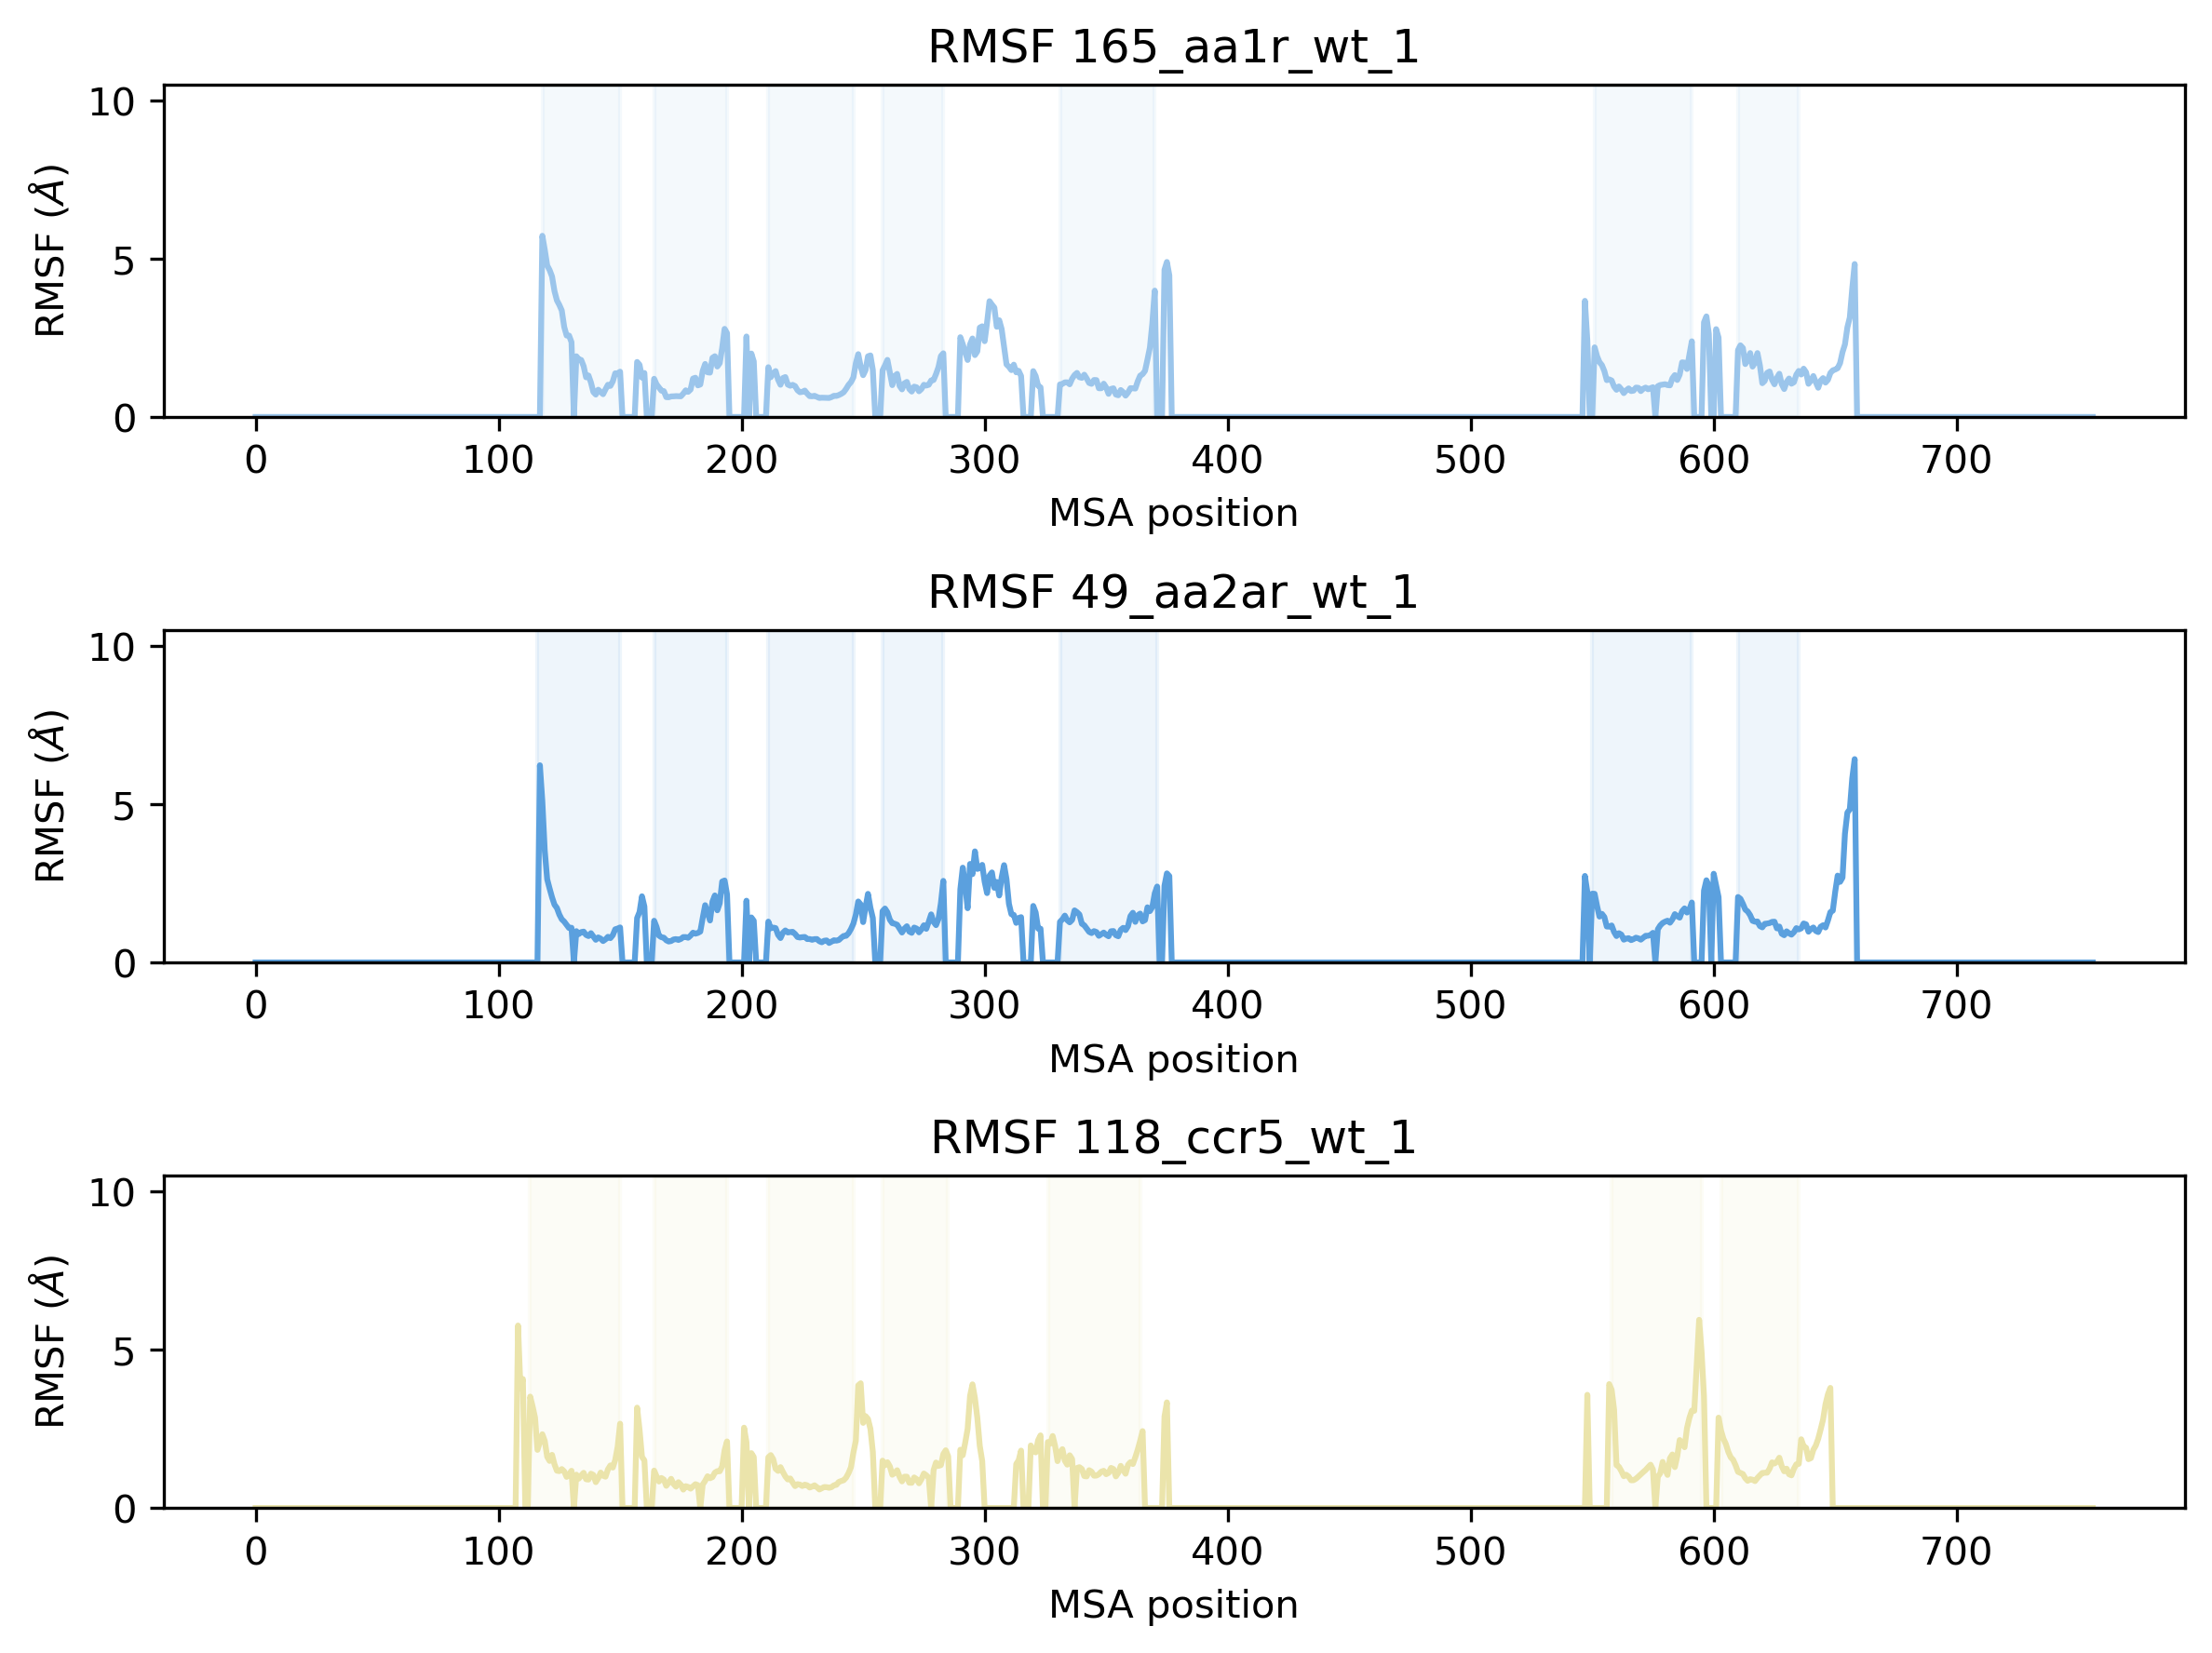

In [5]:
# Options for RMSF calculation and plotting 
md_options_aligned = {
    'MSA_file': msa_file, # Points to the MSA to align the RMSF to for comparison purposes
    'normalize':False, # Relevant for mutants, to normalize respect to WT
    'save_plot':True, # Whether to save the plot
    'plot_align':True, # Whether to align RMSF to input MSA
    'plot_segments':True, # Whether to plot GPCR TM domains as segments 
    'plot_normalize':False, # Whether to plot normalized values
    'average_replicates':False, # Whether to use several replicates and their average 
    'output_dir': out_path # Path to save the plot 
}

# RMSF calculation 
wt_traj_aligned = MD_analysis.MDTrajectory(gpcrmd_path,tutorial_entries,**md_options_aligned)
# RMSF plotting 
wt_traj_aligned.plot_rmsf(alias='tutorial')

Now it is easier to compare the dynamic fluctuation of aligned positions on different GPCRs. From the RMSF plots we observe that all GPCRs are more rigid at the transmembrane (TM) domains, which are shaded, as expected. We also observe that there are differences between the dynamic behavior at the same alignment position between the three targets. We will exploit this information with the 3DDPDs. 

#### Binding pocket selection for 3DDPD calculation

We can calculate 3DDPDs based on the dynamic infomation of the whole protein, but we can also define a selection of the protein residues that we want to focus on. For this, we developed an algorithm to define binding pockets based on the structure of available protein-ligand complex. This algorithm analyzes the available structural data on GPCRdb and extracts the residues involved in ligand binding at different levels: for the target of interest, or all members of its class, family or subfamily. 
For this tutorial, let's focus on two binding pocket selections: class, and subfamily (apart from the whole sequence). 

**NOTE**: The binding pocket selection algorithm was developed with GPCRs in mind and, therefore, leverages curated data from the GPCRdb database. However, the principle behind it can be applied to any protein family with data obtained from e.g. PDBBind (for ligand-protein complexes) and ChEMBL (for hierarchy classification). Feel free to contribute to the code by adding this option to the package!  

##### Option 1: Class A (GPCRdb definition)

In [8]:
# Define options for binding pocket selection
bp_options_class = {
    'target_input': 'aa1r_human,aa2ar_human,ccr5_human', # Targets of interest
    'hierarchy': 'gpcrdbA', # Level for binding pocket selection (pre-defined GCPRdb class A)
    'species_input': 'Homo sapiens', # Organism to include 
    'output_type': ['c','d', 'e'], # Output binding pocket selection as MDtraj output and binding pocket MSA
    'precision': 90, # Minimum MSA alignment precision
    'allosteric': 0, # Overlap between the defined binding pockets and the GPCRdb binding pocket 
    'target_input_alias': 'tutorial',
    'output_dir': out_path # Path to save the binding pocket selection
}
# Calculate binding pocket and extract output 
bp_class = StructBindingPocket.BindingPocket(**bp_options_class)
bp_class.get_output()


#####################################################################

Target input: aa1r_human | Hierarchy level: gpcrdbA
Length of binding pocket MSA: 136
Length of subset binding pocket MSA: 136
Number of residues in subset binding pocket: 129

#####################################################################


#####################################################################

Target input: aa2ar_human | Hierarchy level: gpcrdbA
Length of binding pocket MSA: 136
Length of subset binding pocket MSA: 136
Number of residues in subset binding pocket: 131

#####################################################################


#####################################################################

Target input: ccr5_human | Hierarchy level: gpcrdbA
Length of binding pocket MSA: 136
Length of subset binding pocket MSA: 138
Number of residues in subset binding pocket: 137

#####################################################################

=================== Binding pocket / MS

Here we observe that the length of the binding pocket MSA is common to all targets (136), as it includes data from all Class A GPCRs. However, some targets have certain gaps in the binding pocket defined.

##### Option 2: Subfamily

In [7]:
# Define options for binding pocket selection
bp_options_subfamily = {
    'target_input': 'aa1r_human,aa2ar_human,ccr5_human', # Targets of interest
    'hierarchy': 'subfamily', # Level for binding pocket selection (GCPRdb subfamily)
    'species_input': 'Homo sapiens', # Organism to include 
    'output_type': ['c','d', 'e'], # Output binding pocket selection as MDtraj output and binding pocket MSA
    'precision': 90, # Minimum MSA alignment precision
    'allosteric': 0, # Overlap between the defined binding pockets and the GPCRdb binding pocket 
    'target_input_alias': 'tutorial',
    'output_dir': out_path # Path to save the binding pocket selection
}
# Calculate binding pocket and extract output 
bp_subfamily = StructBindingPocket.BindingPocket(**bp_options_subfamily)
bp_subfamily.get_output()


aa1r_human - analyzing and preparing 
Structures analyzed: (5)
   5N2S removed | Non-standardized AA sequence numbering.
37 AAs correctly aligned out of 37.(100.0%)
Total structures used for binding pocket:    (4)

aa2ar_human - analyzing and preparing 
Structures analyzed: (66)
42 AAs correctly aligned out of 71.(59.2%)
   5NLX removed | High alignment missmatch (4.166666666666666%). 
42 AAs correctly aligned out of 71.(59.2%)
   5NM4 removed | High alignment missmatch (4.166666666666666%). 
41 AAs correctly aligned out of 49.(83.7%)
   7T32 removed | High alignment missmatch (42.857142857142854%). 
40 AAs correctly aligned out of 40.(100.0%)
Total structures used for binding pocket:    (63)

aa2br_human - analyzing and preparing 
Structures analyzed: (0)

aa3r_human - analyzing and preparing 
Structures analyzed: (0)

#####################################################################

Target input: aa1r_human | Hierarchy level: subfamily
Number of proteins in subfamily subset: 4


The length of the binding pocket MSA using the subfamily is the same for memebrs of the same subfamily (aa1r and aa2ar; 54 residues), but different for members of a different subfamily (ccr5; 76 residues). This will have an implication for the calculation and applicability of 3DDPDs.

### 3DDPD calculation

3D dynamic protein descriptors (3DDPDs) can be calculated from MD trajectories to describe both the composition (atomic partial charges) as well as the movement (coordinate variation) of a protein, which can then be applied in, for example, machine learning models. 
3DDPDs come in two flavors:
1. **rs3DDPD**: residue-specific 3DDPDs, which are one-hot encoded descriptors with a fixed number of features assigned to each residue in the protein. 
2. **ps3DDPD**: protein-specific 3DDPDs, which are embedding-like descriptors with a fixed number of features assigned to each protein and that cannot be traced back to individual residues.

#### rs3DDPD (residue-specific)

rs3DDPDs are calculated individually for each protein, so they are independent from the rest of the dataset. Let's first calculate rs3DDPDs for the full sequence using the GPCRdb pre-calculated alignment that we used to analyze the MD simulations.

In [23]:
bp_options_full_sequence = {
    'MSA_input_file': msa_file,
    'BP_input_file': bp_file # Not relevant as the option to select residues is off, but needed as input
}

DynDescriptor.rs3ddpd_generation(md_dir = gpcrmd_path, # Path to MD trajectories
                                 desc_dir = out_path, # Path to output directory
                                 input_entries = tutorial_entries, # Trajectories to analyze
                                 input_alias = 'tutorial', # Prefix for output file
                                 frame_split = 100, # Number of frames in sub-trajectory
                                 user_flex = 'std', # Choice of atom flexibility data: 'std' = SD x/y/z-coordinates + Gasteiger Charge
                                 sel_atoms = 'all', # Use data from all heavy atoms
                                 sel_residues = False, # Whether to apply the residue selection from bp_option
                                 pca_explain = 0.99, # % of variance covered by atom PCA
                                 numberpc = 5, # Number of principal components (PC) in residue PCA
                                 other_desc = None, # Other descriptors to append 
                                 **bp_options_full_sequence # Binding pocket selection options
                                )

Reading MSA and binding pocket selection from json files...
Done
Descriptor file tutorial_3DDPD_RS_std_f100_pc5_fs_aa.txt exists in output directory.
Summary report of previous calculation was:

#####################################################################
SUMMARY - tutorial_3DDPD_RS_std_f100_pc5_fs_aa:
Entries/targets:           165_aa1r_wt_1,49_aa2ar_wt_1,118_ccr5_wt_1
 - Atom data:      SD x/y/z-coordinates + Gasteiger Charge.
 - Framesplit:     100 frames.
 - Atom PCs:       99.0% variance explained
      Average # Atom PCs:                       [58.0]
      SD # Atom PCs:                            [2.0]
 - Residue PCs:    5 PCs.
     Average explained variance per residue PC: [16.8, 2.5, 2.3, 2.2, 2.2]
     Average explained variance total:          [26.0]
     SD explained variance total:               [0.4]
 - Atom select:    All atoms.
 - Residue select: All residues.
 - Other descr.:   None.

#####################################################################


And to get an initial idea of the differences between descriptors, we can visualize them:

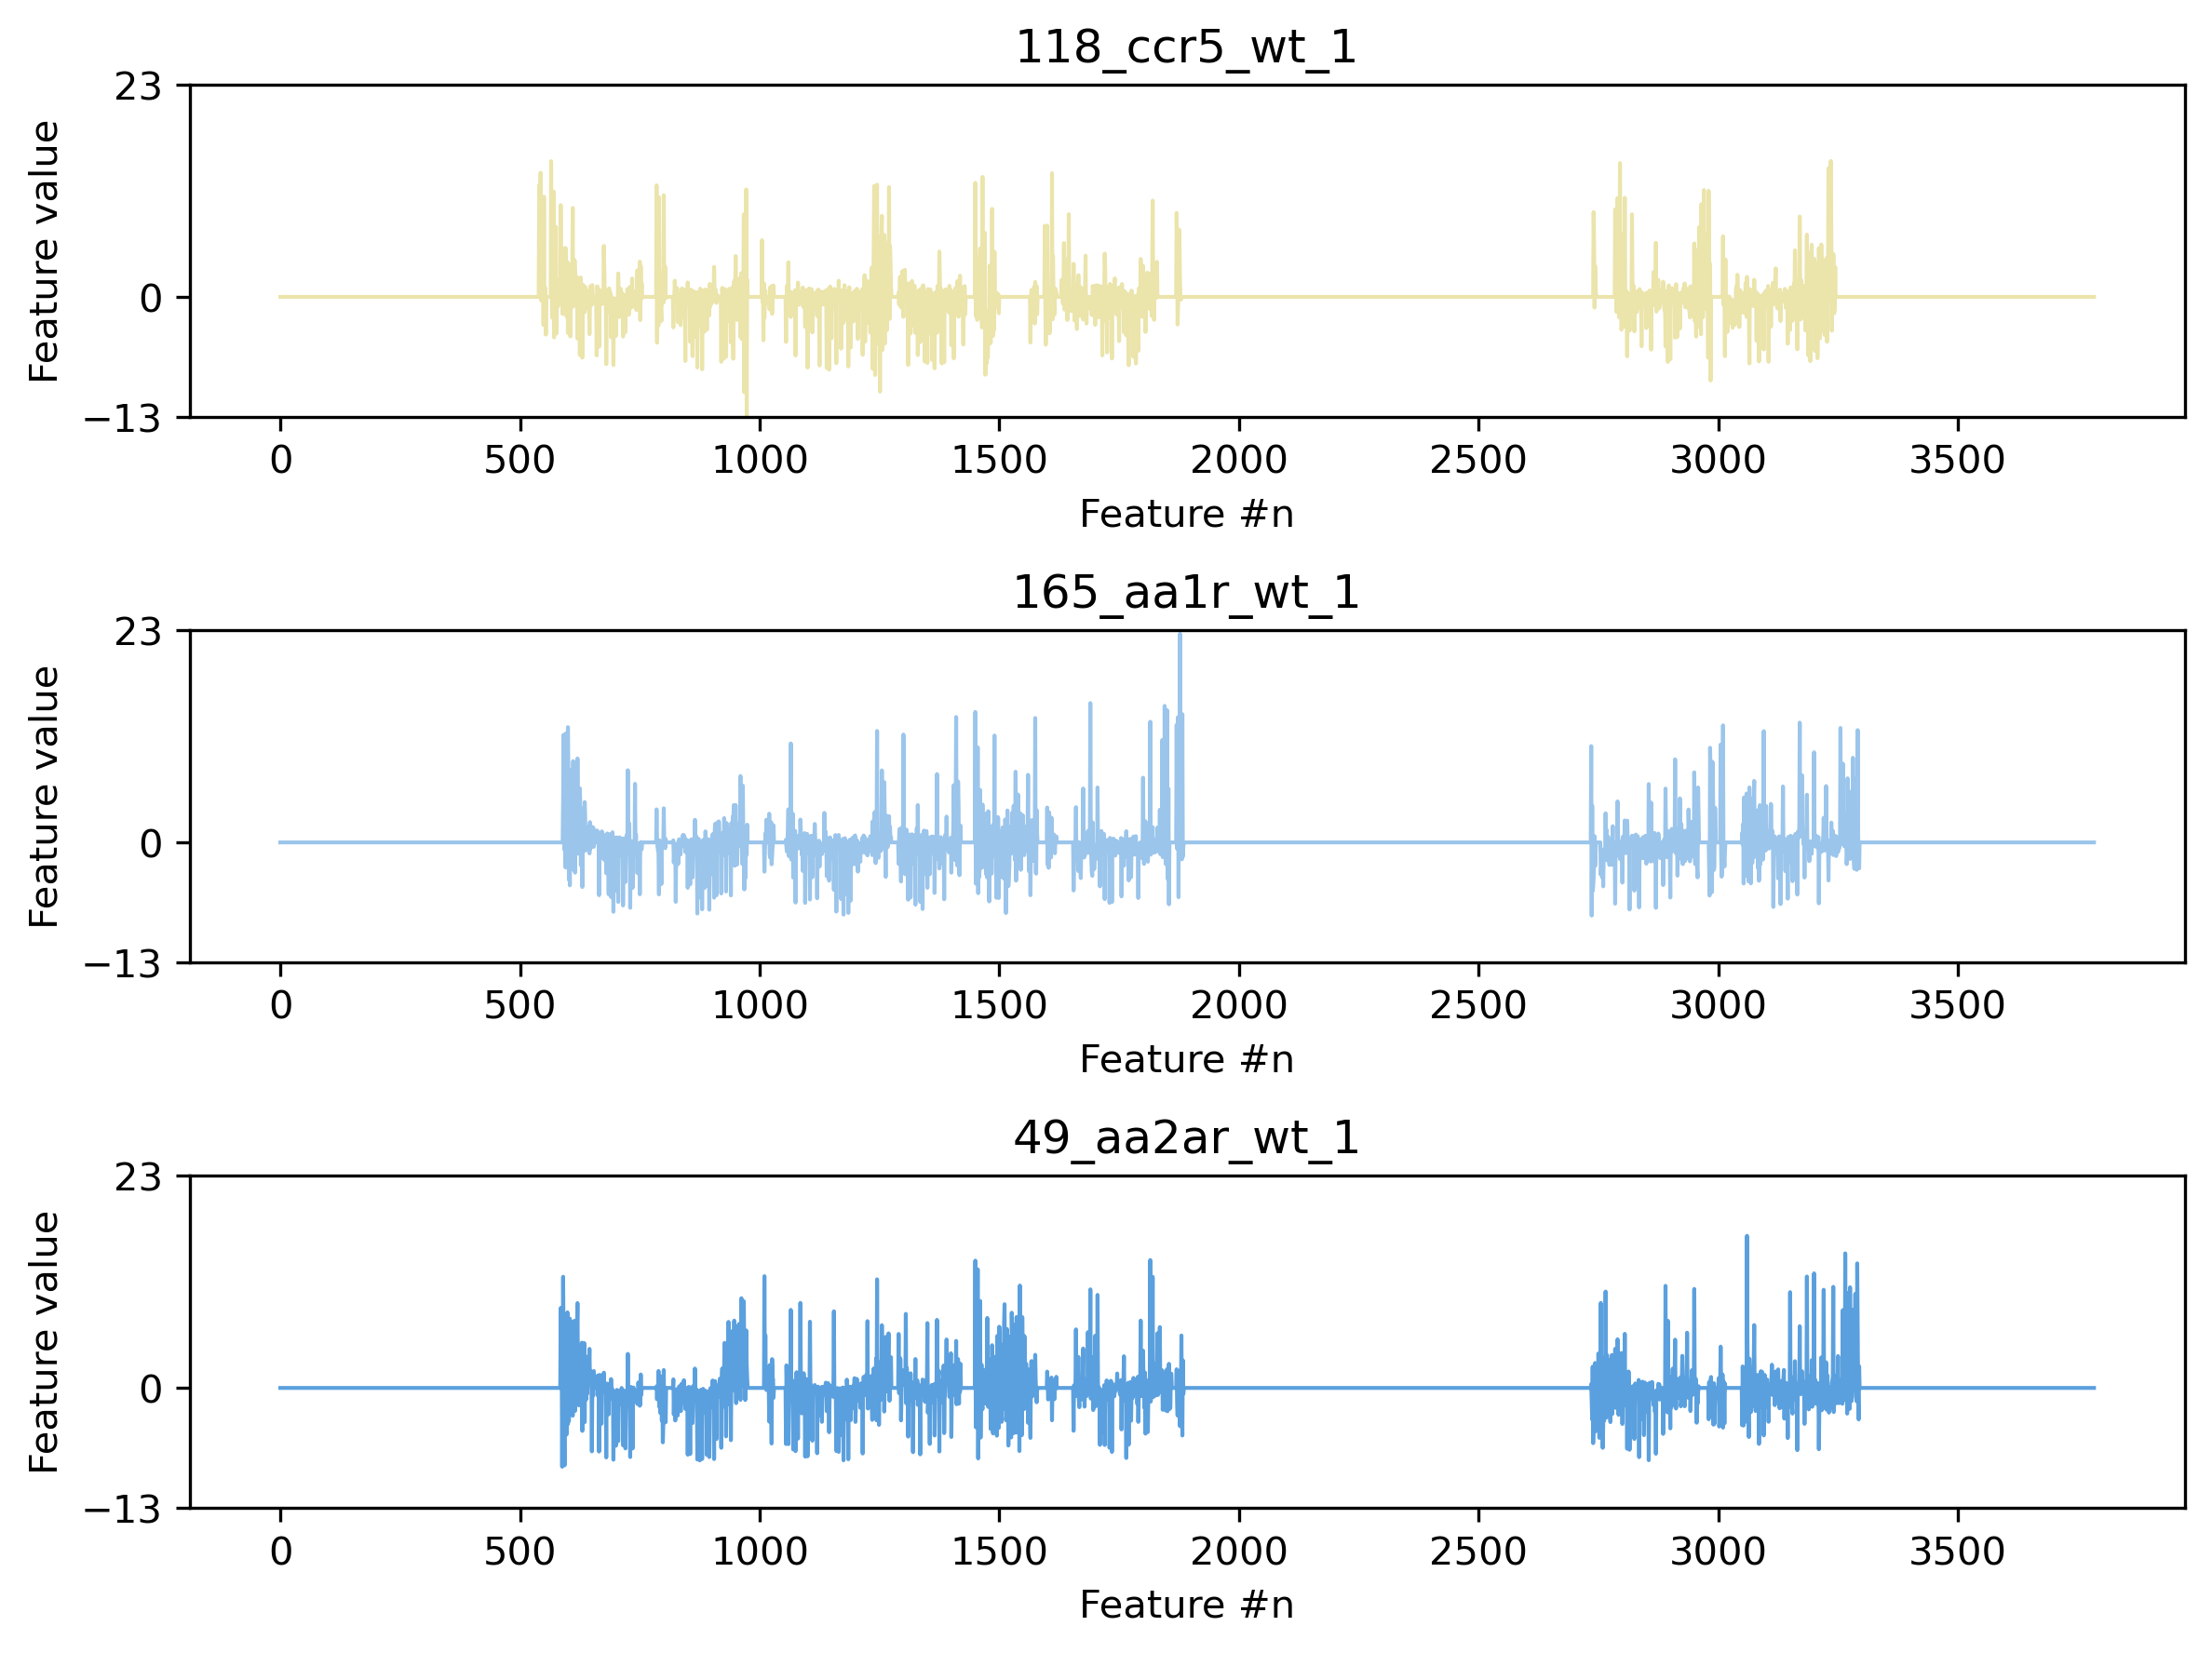

In [22]:
for descriptor_name in ['tutorial_3DDPD_RS_std_f100_pc5_fs_aa']:
    descriptor = DynDescriptor.Descriptor(out_path,descriptor_name,out_path)
    descriptor.plot_all_entries_one_col(subset=None, title_var='entry', save=True)

Since we used the same MSA that we used to align the RMSF and we did not make a residue selection, we can compare one-to-one the descriptor values that were generated for each residue. The rs3DDPD has similarities to the RMSF patterns, but it does not correlate completely, because the 3DDPD is constructed not only from the trajectory coordinates, but also from the protein composition, which is not reflected in RMSF.

The descriptors have many zero values that correspond to gaps in the MSA. For prospective application on machine learning models, we would prune the descriptor by applying feature selection strategies. Here, we could remove all features that have small variance between targets, so that the model only gets the most informative part of the descriptor. 

Apart from using the whole protein, we can also calculate 3DDPDs with residue selection options. The binding pocket selection and MSA previously calculated can be parsed as part of the bp_options dictionary or calculated on the fly again. Here we will use the class and subfamily hierarchies as examples.

In [9]:
bp_options_class = {
    'MSA_input_file': os.path.join(out_path,'MSA_bp_tutorial_Homo sapiens_gpcrdbA_precision90_allosteric0.json'),
    'BP_input_file': os.path.join(out_path,'BP_MDtraj_tutorial_Homo sapiens_gpcrdbA_precision90_allosteric0.json')
}
bp_options_subfamily = {
    'MSA_input_file': os.path.join(out_path,'MSA_bp_tutorial_Homo sapiens_subfamily_precision90_allosteric0.json'),
    'BP_input_file': os.path.join(out_path,'BP_MDtraj_tutorial_Homo sapiens_subfamily_precision90_allosteric0.json')
}

We then calculate the rs3DDPD with the options of interest:

In [10]:
for bp_options in [bp_options_class, bp_options_subfamily]:
    DynDescriptor.rs3ddpd_generation(md_dir = gpcrmd_path, # Path to MD trajectories
                                     desc_dir = out_path, # Path to output directory
                                     input_entries = tutorial_entries, # Trajectories to analyze
                                     input_alias = 'tutorial', # Prefix for output file
                                     frame_split = 100, # Number of frames in sub-trajectory
                                     user_flex = 'std', # Choice of atom flexibility data: 'std' = SD x/y/z-coordinates + Gasteiger Charge
                                     sel_atoms = 'all', # Use data from all heavy atoms
                                     sel_residues = True, # Whether to apply the residue selection from bp_option
                                     pca_explain = 0.99, # % of variance covered by atom PCA
                                     numberpc = 5, # Number of principal components (PC) in residue PCA
                                     other_desc = None, # Other descriptors to append 
                                     **bp_options) # Binding pocket selection options

Reading MSA and binding pocket selection from json files...
Done

Now processing: (165_aa1r_wt_1)
Total MD size:          <mdtraj.Trajectory with 2500 frames, 28688 atoms, 17528 residues, and unitcells>
Protein MD size:        <mdtraj.Trajectory with 2500 frames, 2442 atoms, 309 residues, and unitcells>
Residue select MD size: <mdtraj.Trajectory with 2500 frames, 1006 atoms, 129 residues, and unitcells>
Atom select MD size:    <mdtraj.Trajectory with 2500 frames, 1006 atoms, 129 residues, and unitcells>
Number of atom PCs:             54
Explained variance per atom PC: [0.65533748 0.06424549 0.04619768 0.02712655 0.01620875 0.01570607
 0.01522576 0.01307255 0.01138386 0.01082926 0.00937767 0.00840527
 0.00680958 0.00599735 0.00562195 0.00517657 0.00481108 0.00452491
 0.00423012 0.0039126  0.00370702 0.0034119  0.00322857 0.00307597
 0.00278415 0.00256854 0.00237163 0.00229614 0.00212802 0.00202566
 0.00197727 0.00189133 0.00174417 0.00170071 0.00156752 0.00147336
 0.00145167 0.00135886

And we can plot the rs3DDPDs to observe the differences when using more strict residue selections.

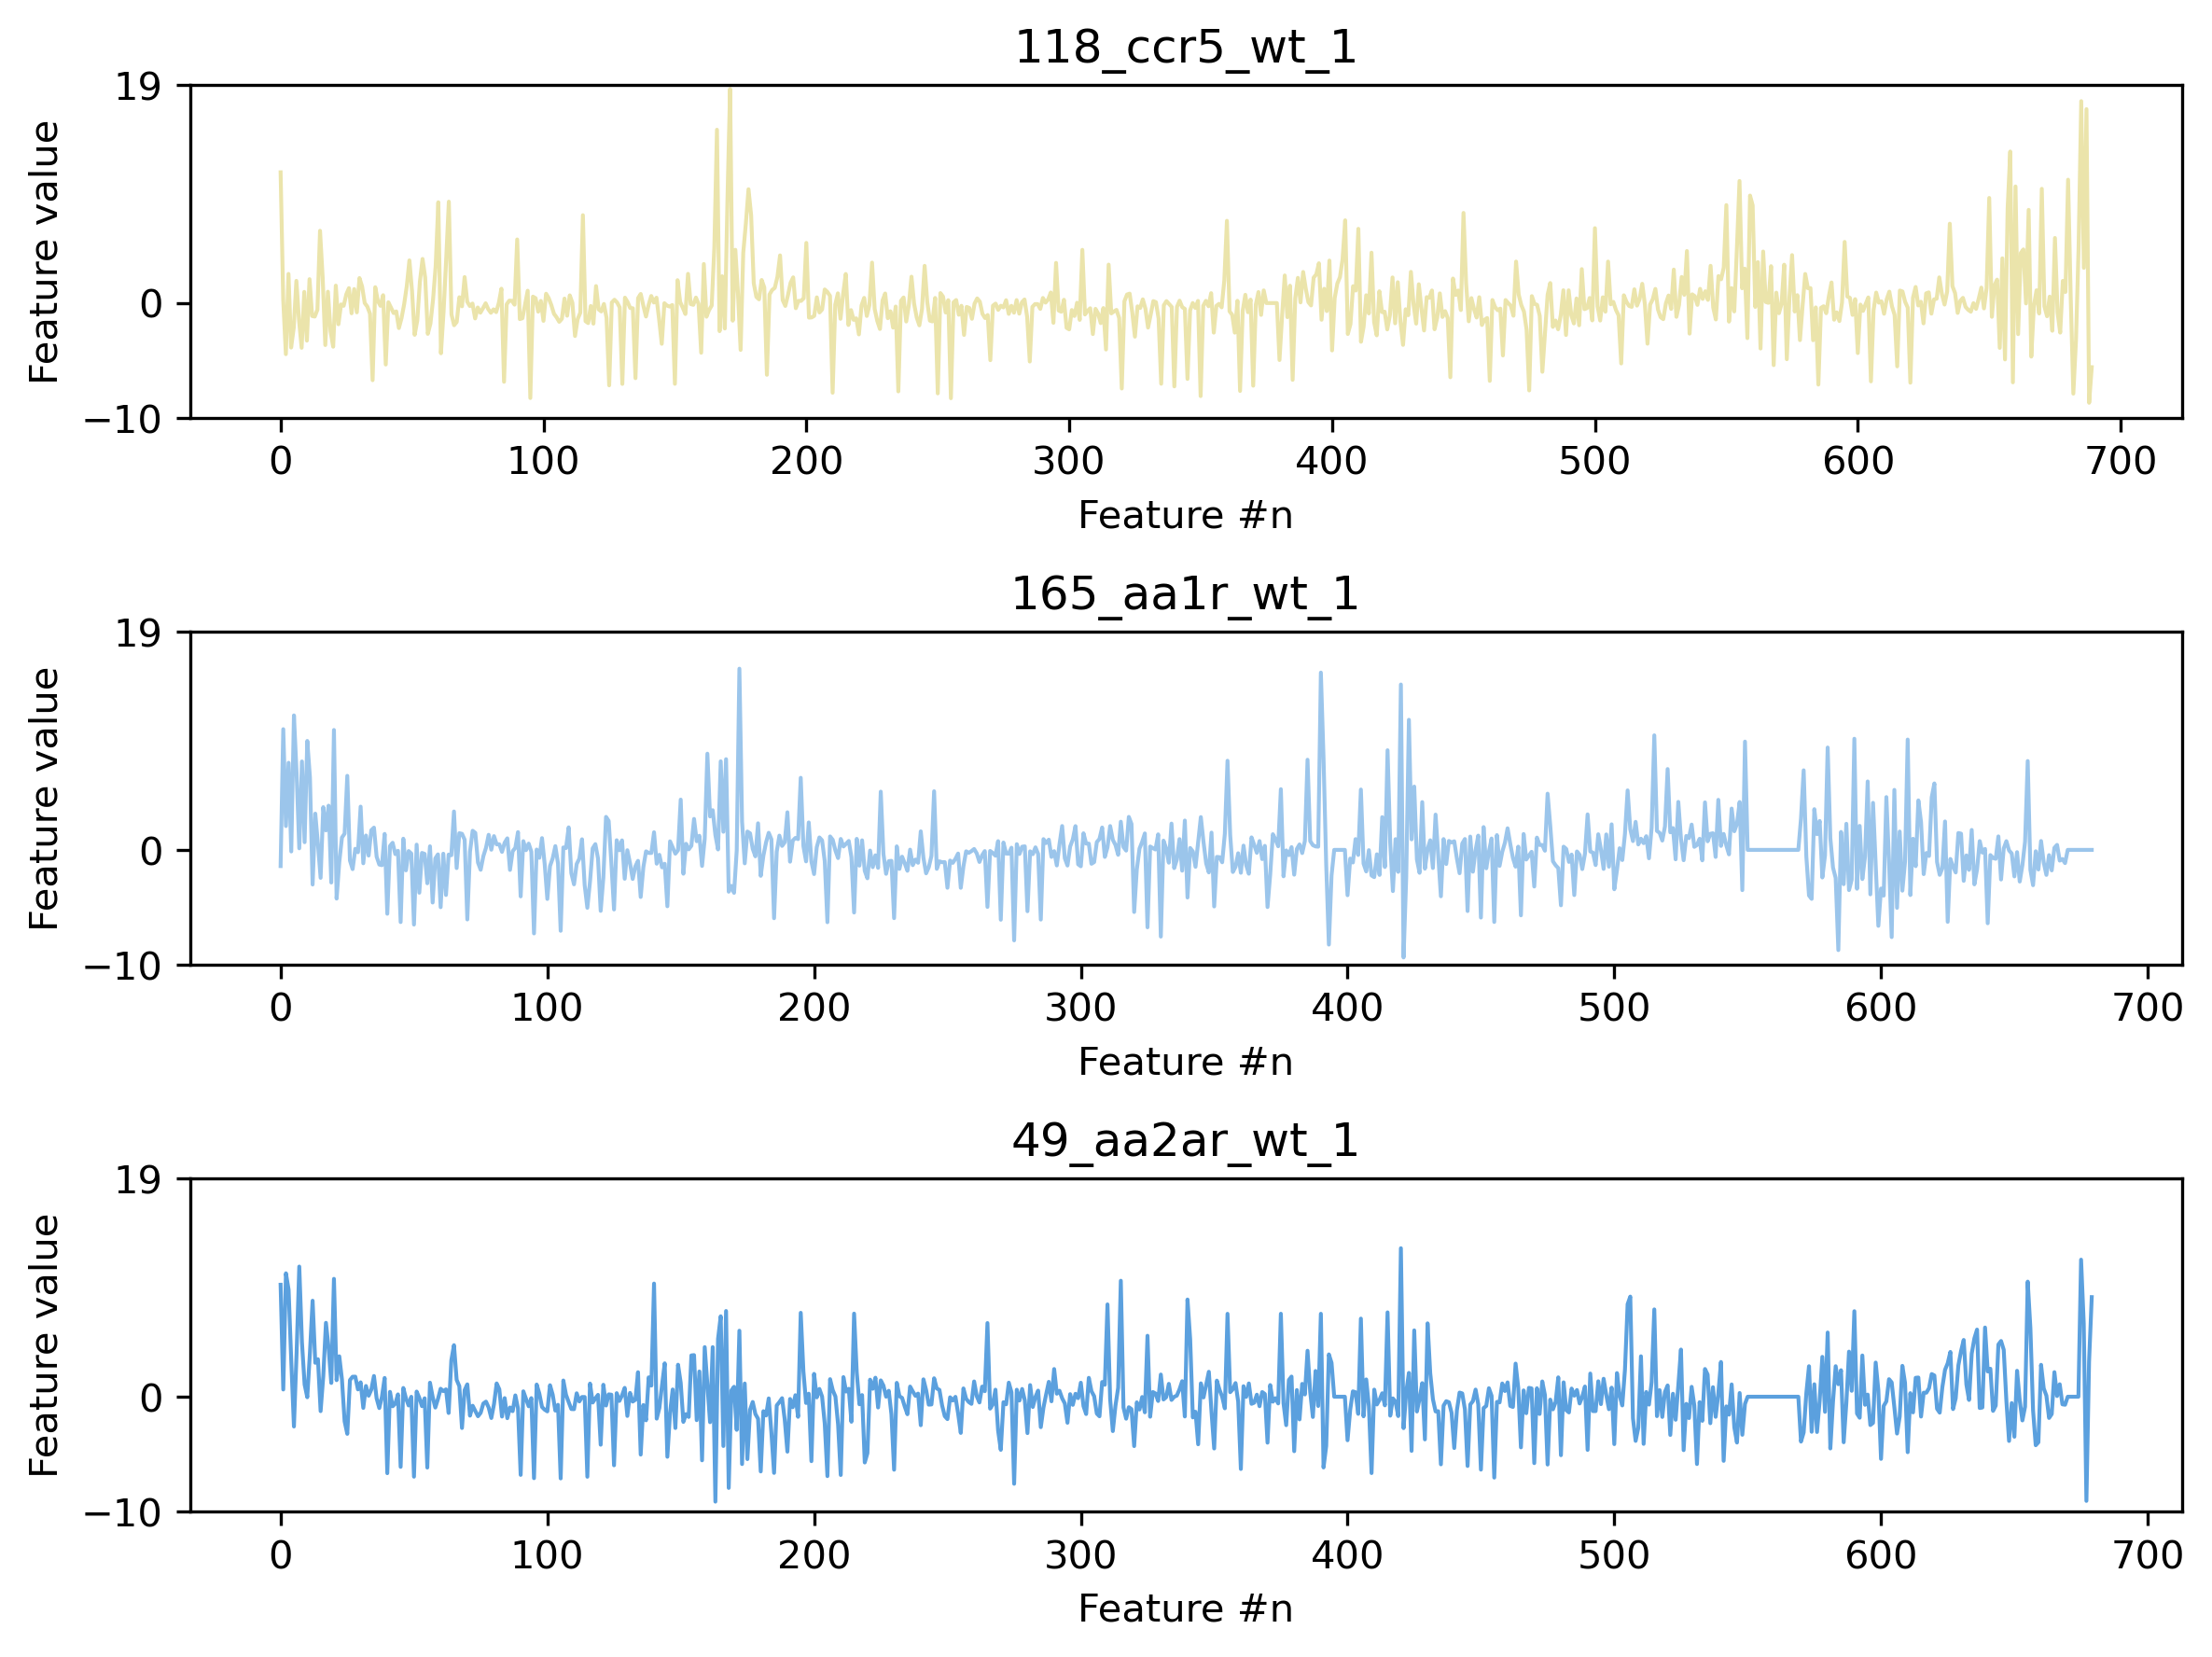

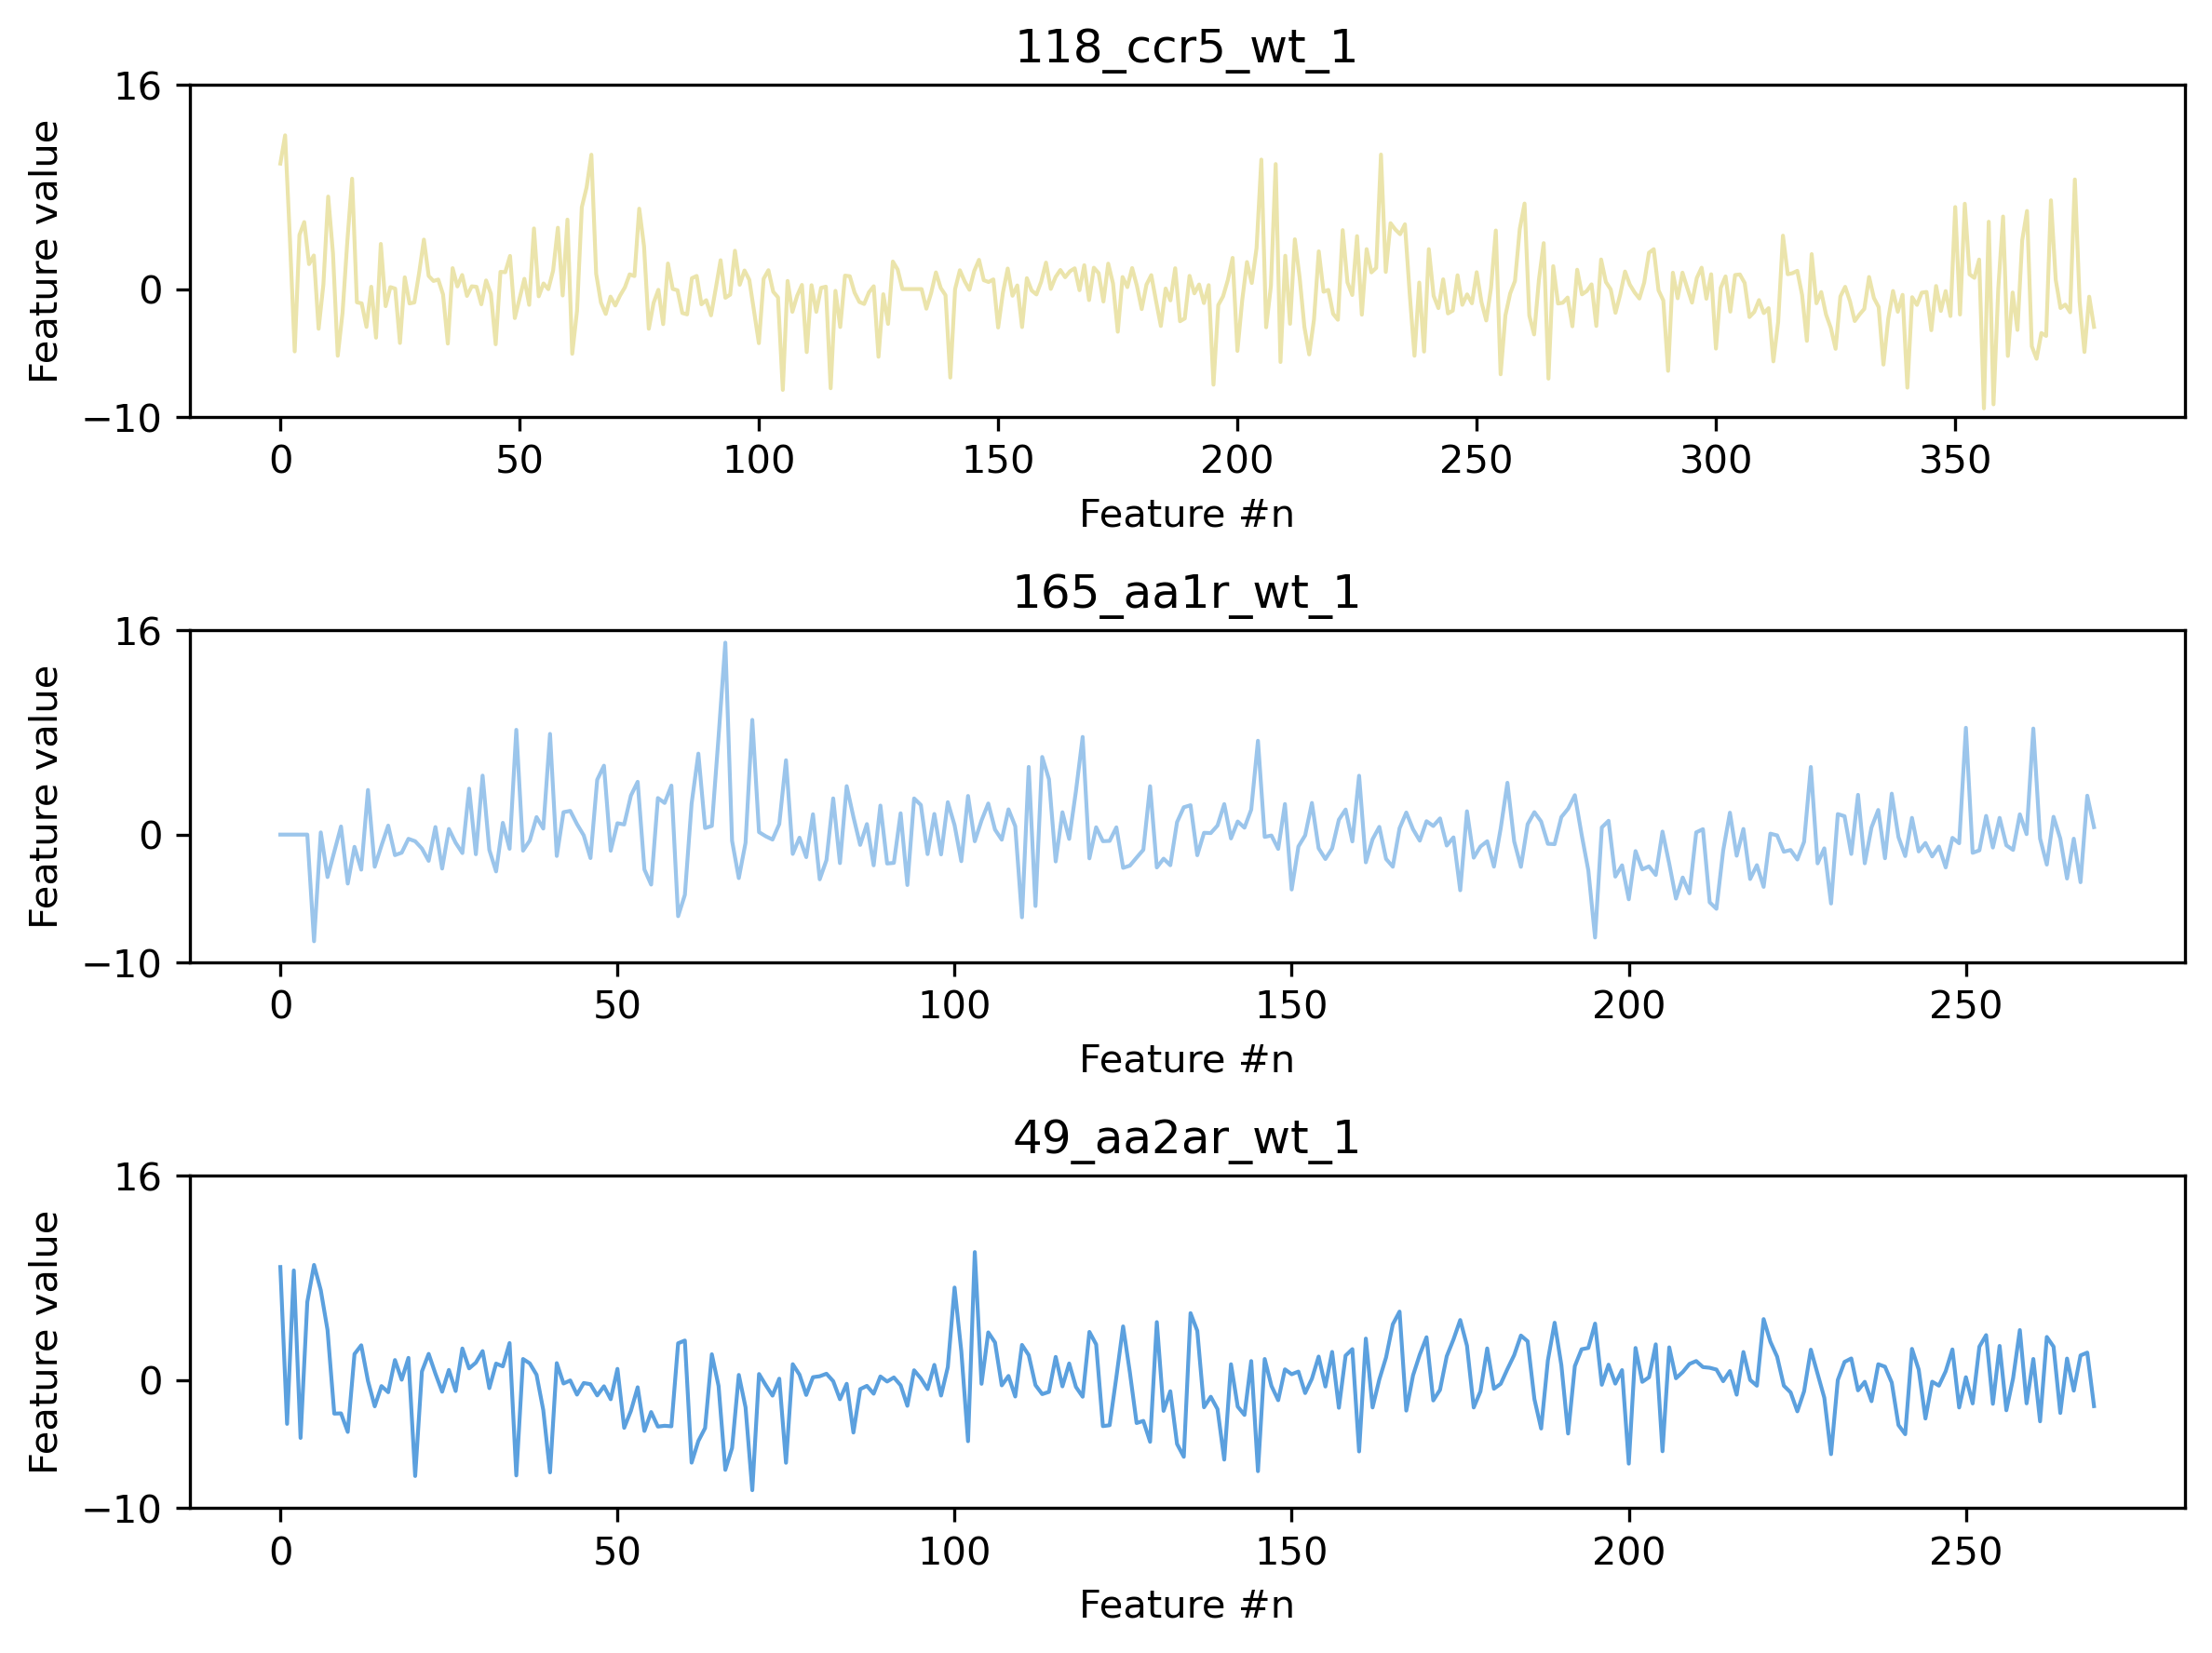

In [11]:
for descriptor_name in ['tutorial_3DDPD_RS_std_f100_pc5_ga_aa','tutorial_3DDPD_RS_std_f100_pc5_sf_aa']:
    descriptor = DynDescriptor.Descriptor(out_path,descriptor_name,out_path)
    descriptor.plot_all_entries_one_col(subset=None, title_var='entry', save=True)

Here, we can observe that the rs3DDPDs generated with a residue selection are shorter, because the number of residues used is smaller. When the binding pocket selection is made on the class level (top figure), the number of features for each target is the same because they are all part of the same class so the binding pocket MSA has the same length. However, when the residue selection is done per subfamily (bottom figure), the number of features is different for targets of different subfamilies because the binding pocket MSA has different length. This is important because all targets need to have the same descriptor length for machine learning applications. 

#### ps3DDPD (protein-specific)

Now we calculate protein-specific (ps)3DDPDs, which are calculated simultaneously for all targets to exploit the differences between targets in a set. They are calculated very simialrly to rs3DDPDs: first, we load the right MSA and binding pocket selection and then define the rest of parameters for descriptor generation.

In [27]:
DynDescriptor.ps3ddpd_generation(md_dir = gpcrmd_path, # Path to MD trajectories
                                 desc_dir = out_path, # Path to output directory
                                 input_entries = tutorial_entries, # Trajectories to analyze
                                 input_alias = 'tutorial', # Prefix for output file
                                 frame_split = 100, # Number of frames in sub-trajectory
                                 user_flex = 'std', # Choice of atom flexibility data: 'std' = SD x/y/z-coordinates + Gasteiger Charge
                                 sel_atoms = 'all', # Use data from all heavy atoms
                                 sel_residues = False, # Whether to apply the residue selection from bp_option
                                 pca_explain = 0.99, # % of variance covered by atom PCA
                                 **bp_options_full_sequence # Binding pocket selection options
                                )

Reading MSA and binding pocket selection from json files...
Done

Now processing: (165_aa1r_wt_1)
Total MD size:          <mdtraj.Trajectory with 2500 frames, 28688 atoms, 17528 residues, and unitcells>
Protein MD size:        <mdtraj.Trajectory with 2500 frames, 2442 atoms, 309 residues, and unitcells>
Residue select MD size: <mdtraj.Trajectory with 2500 frames, 2442 atoms, 309 residues, and unitcells>
Atom select MD size:    <mdtraj.Trajectory with 2500 frames, 2437 atoms, 309 residues, and unitcells>

Now processing: (49_aa2ar_wt_1)
Total MD size:          <mdtraj.Trajectory with 2500 frames, 31184 atoms, 19206 residues, and unitcells>
Protein MD size:        <mdtraj.Trajectory with 2500 frames, 2448 atoms, 313 residues, and unitcells>
Residue select MD size: <mdtraj.Trajectory with 2500 frames, 2448 atoms, 313 residues, and unitcells>
Atom select MD size:    <mdtraj.Trajectory with 2500 frames, 2446 atoms, 313 residues, and unitcells>

Now processing: (118_ccr5_wt_1)
Total MD size:

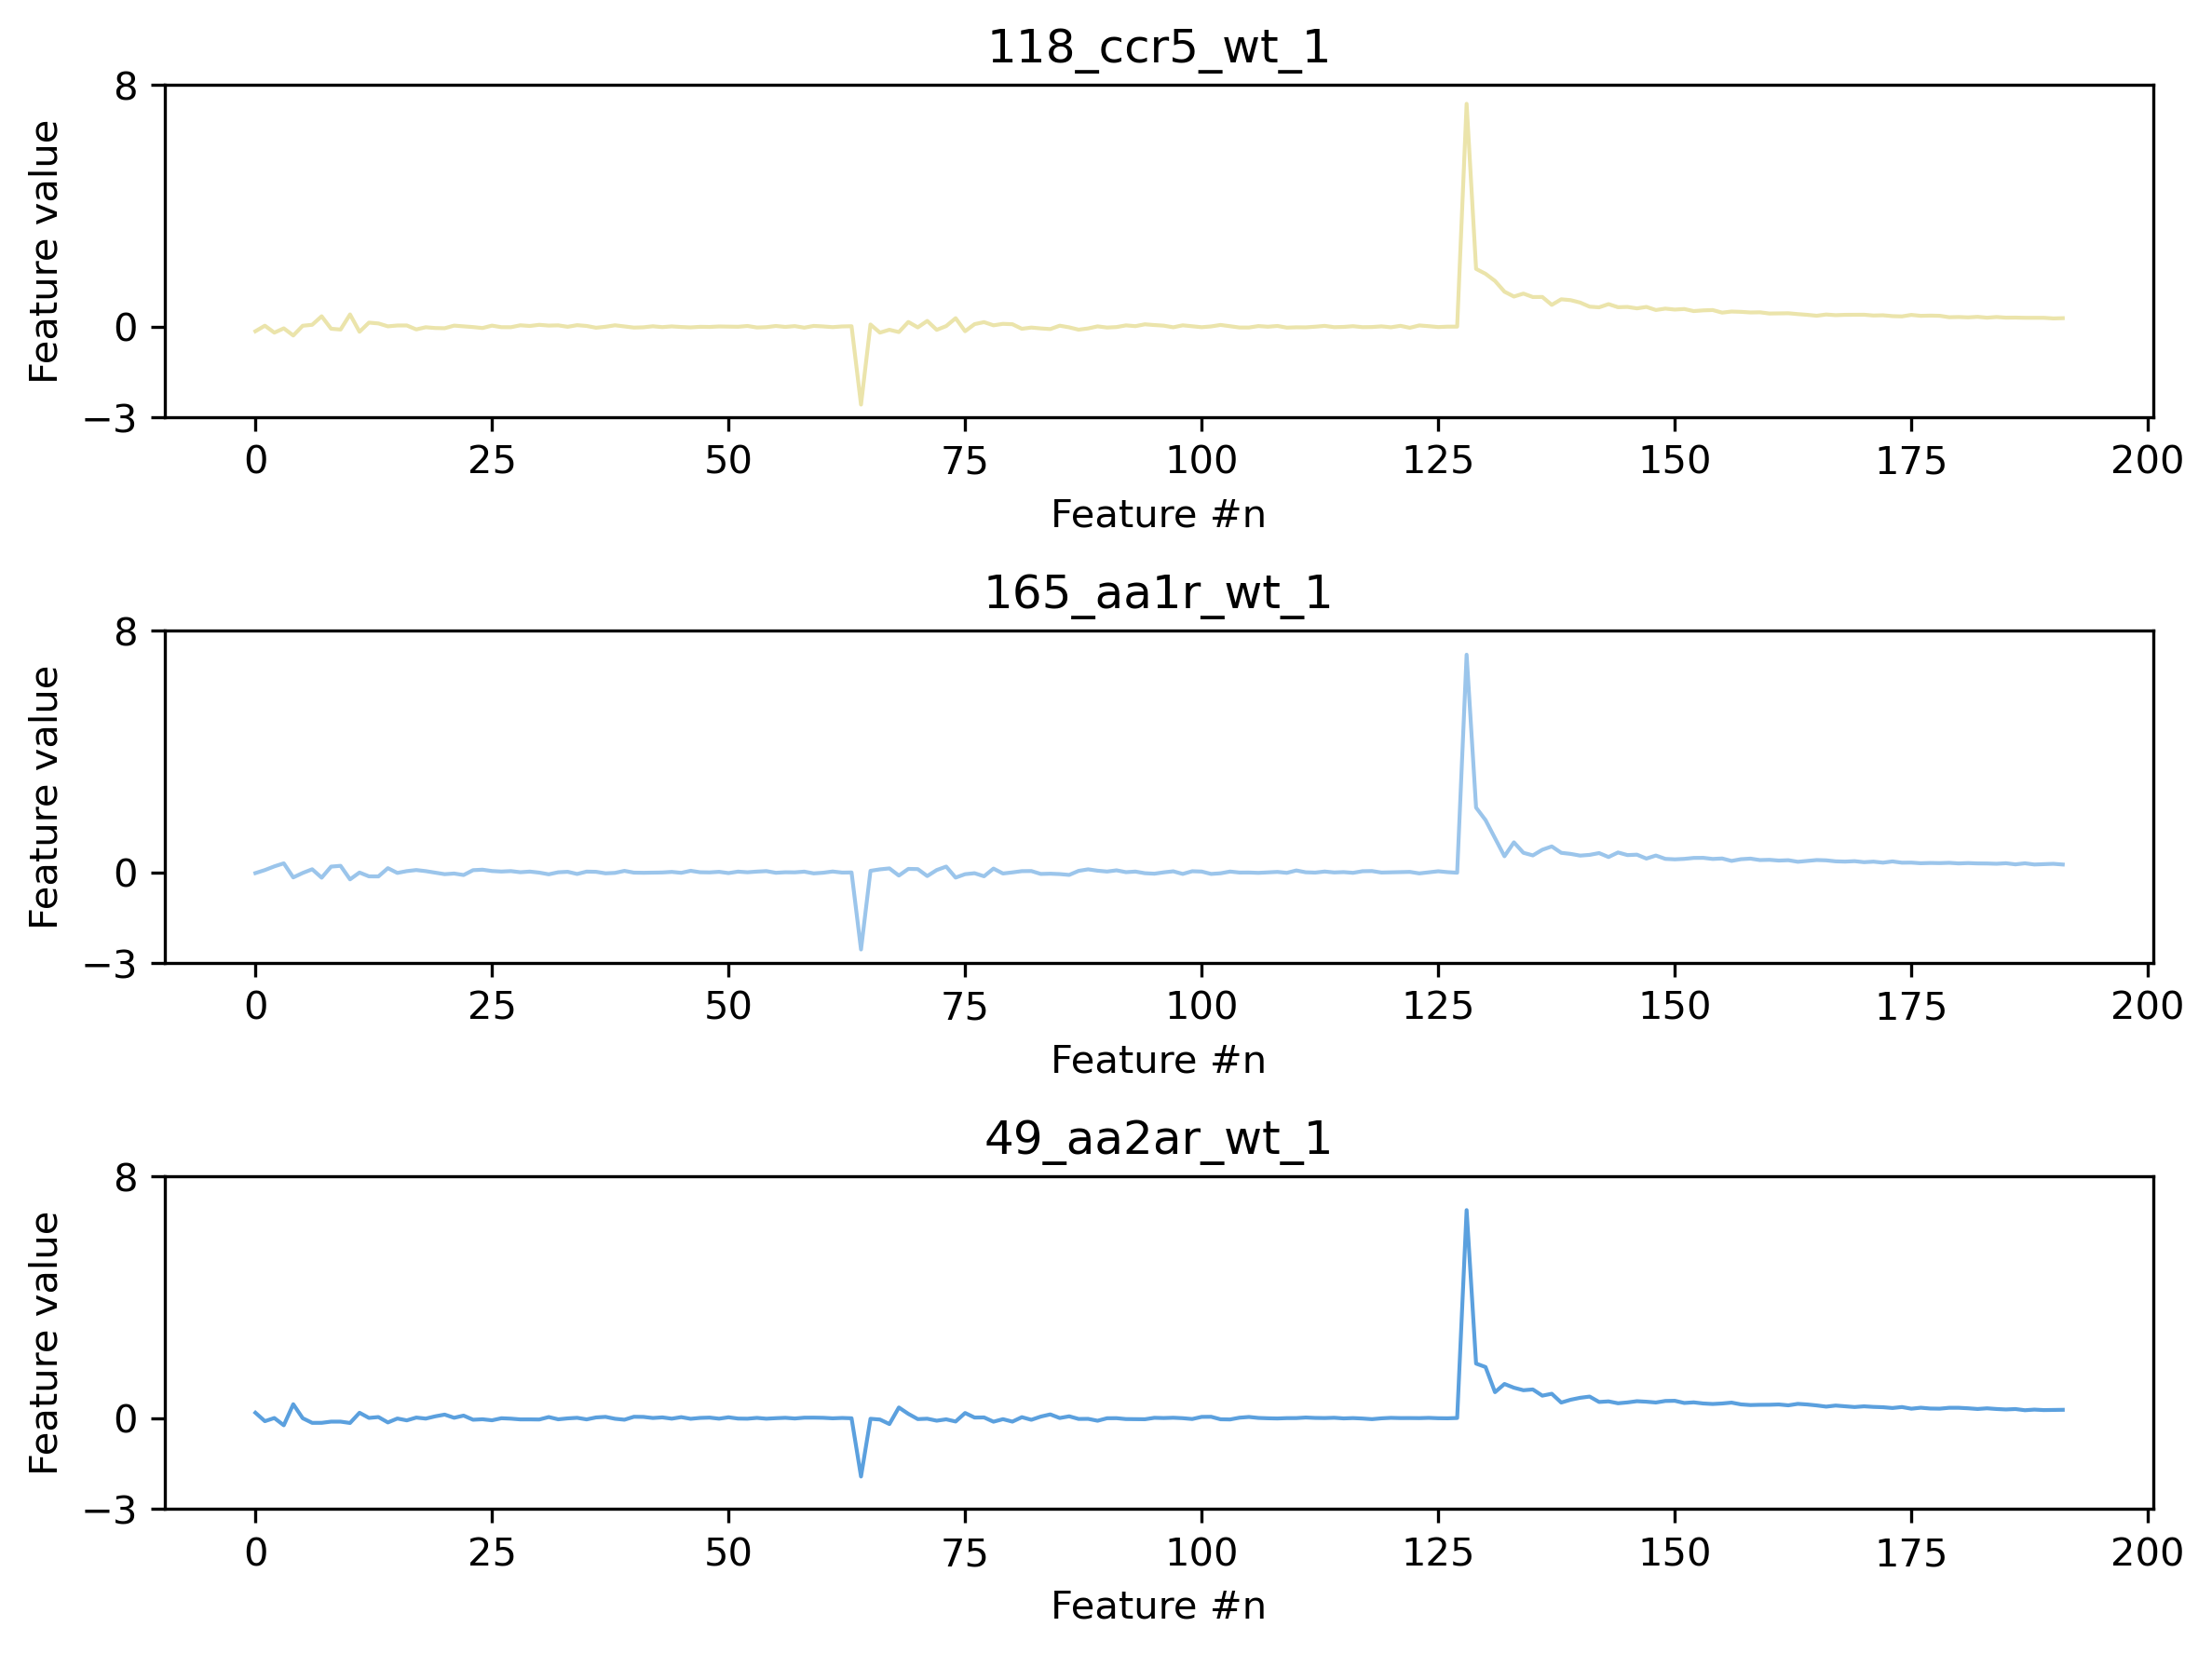

In [29]:
for descriptor_name in ['tutorial_3DDPD_PS_std_f100_pc0.99_fs_aa']:
    descriptor = DynDescriptor.Descriptor(out_path,descriptor_name,out_path)
    descriptor.plot_all_entries_one_col(subset=None, title_var='entry', save=True)

The first observation is that ps3DDPDs are remarkably shorter than rs3DDPDs. This might be of interest depending on the machine learning model used, but it has the disadvantage that the features cannot be traced back to independent residues. Indeed, there is no clear correlation with the RMSF plots, and here we need to "trust" that the computer is generating the right embedding that points at the correct similarities and differences between targets. For this, it might be interesting to take information from a smaller subset of residues: 

In [12]:
for bp_options in [bp_options_class, bp_options_subfamily]:
    DynDescriptor.ps3ddpd_generation(md_dir = gpcrmd_path, # Path to MD trajectories
                                     desc_dir = out_path, # Path to output directory
                                     input_entries = tutorial_entries, # Trajectories to analyze
                                     input_alias = 'tutorial', # Prefix for output file
                                     frame_split = 100, # Number of frames in sub-trajectory
                                     user_flex = 'std', # Choice of atom flexibility data: 'std' = SD x/y/z-coordinates + Gasteiger Charge
                                     sel_atoms = 'all', # Use data from all heavy atoms
                                     sel_residues = True, # Whether to apply the residue selection from bp_option
                                     pca_explain = 0.99, # % of variance covered by atom PCA
                                     **bp_options) # Binding pocket selection options

Reading MSA and binding pocket selection from json files...
Done

Now processing: (165_aa1r_wt_1)
Total MD size:          <mdtraj.Trajectory with 2500 frames, 28688 atoms, 17528 residues, and unitcells>
Protein MD size:        <mdtraj.Trajectory with 2500 frames, 2442 atoms, 309 residues, and unitcells>
Residue select MD size: <mdtraj.Trajectory with 2500 frames, 1006 atoms, 129 residues, and unitcells>
Atom select MD size:    <mdtraj.Trajectory with 2500 frames, 1006 atoms, 129 residues, and unitcells>

Now processing: (49_aa2ar_wt_1)
Total MD size:          <mdtraj.Trajectory with 2500 frames, 31184 atoms, 19206 residues, and unitcells>
Protein MD size:        <mdtraj.Trajectory with 2500 frames, 2448 atoms, 313 residues, and unitcells>
Residue select MD size: <mdtraj.Trajectory with 2500 frames, 1006 atoms, 130 residues, and unitcells>
Atom select MD size:    <mdtraj.Trajectory with 2500 frames, 1006 atoms, 130 residues, and unitcells>

Now processing: (118_ccr5_wt_1)
Total MD size:

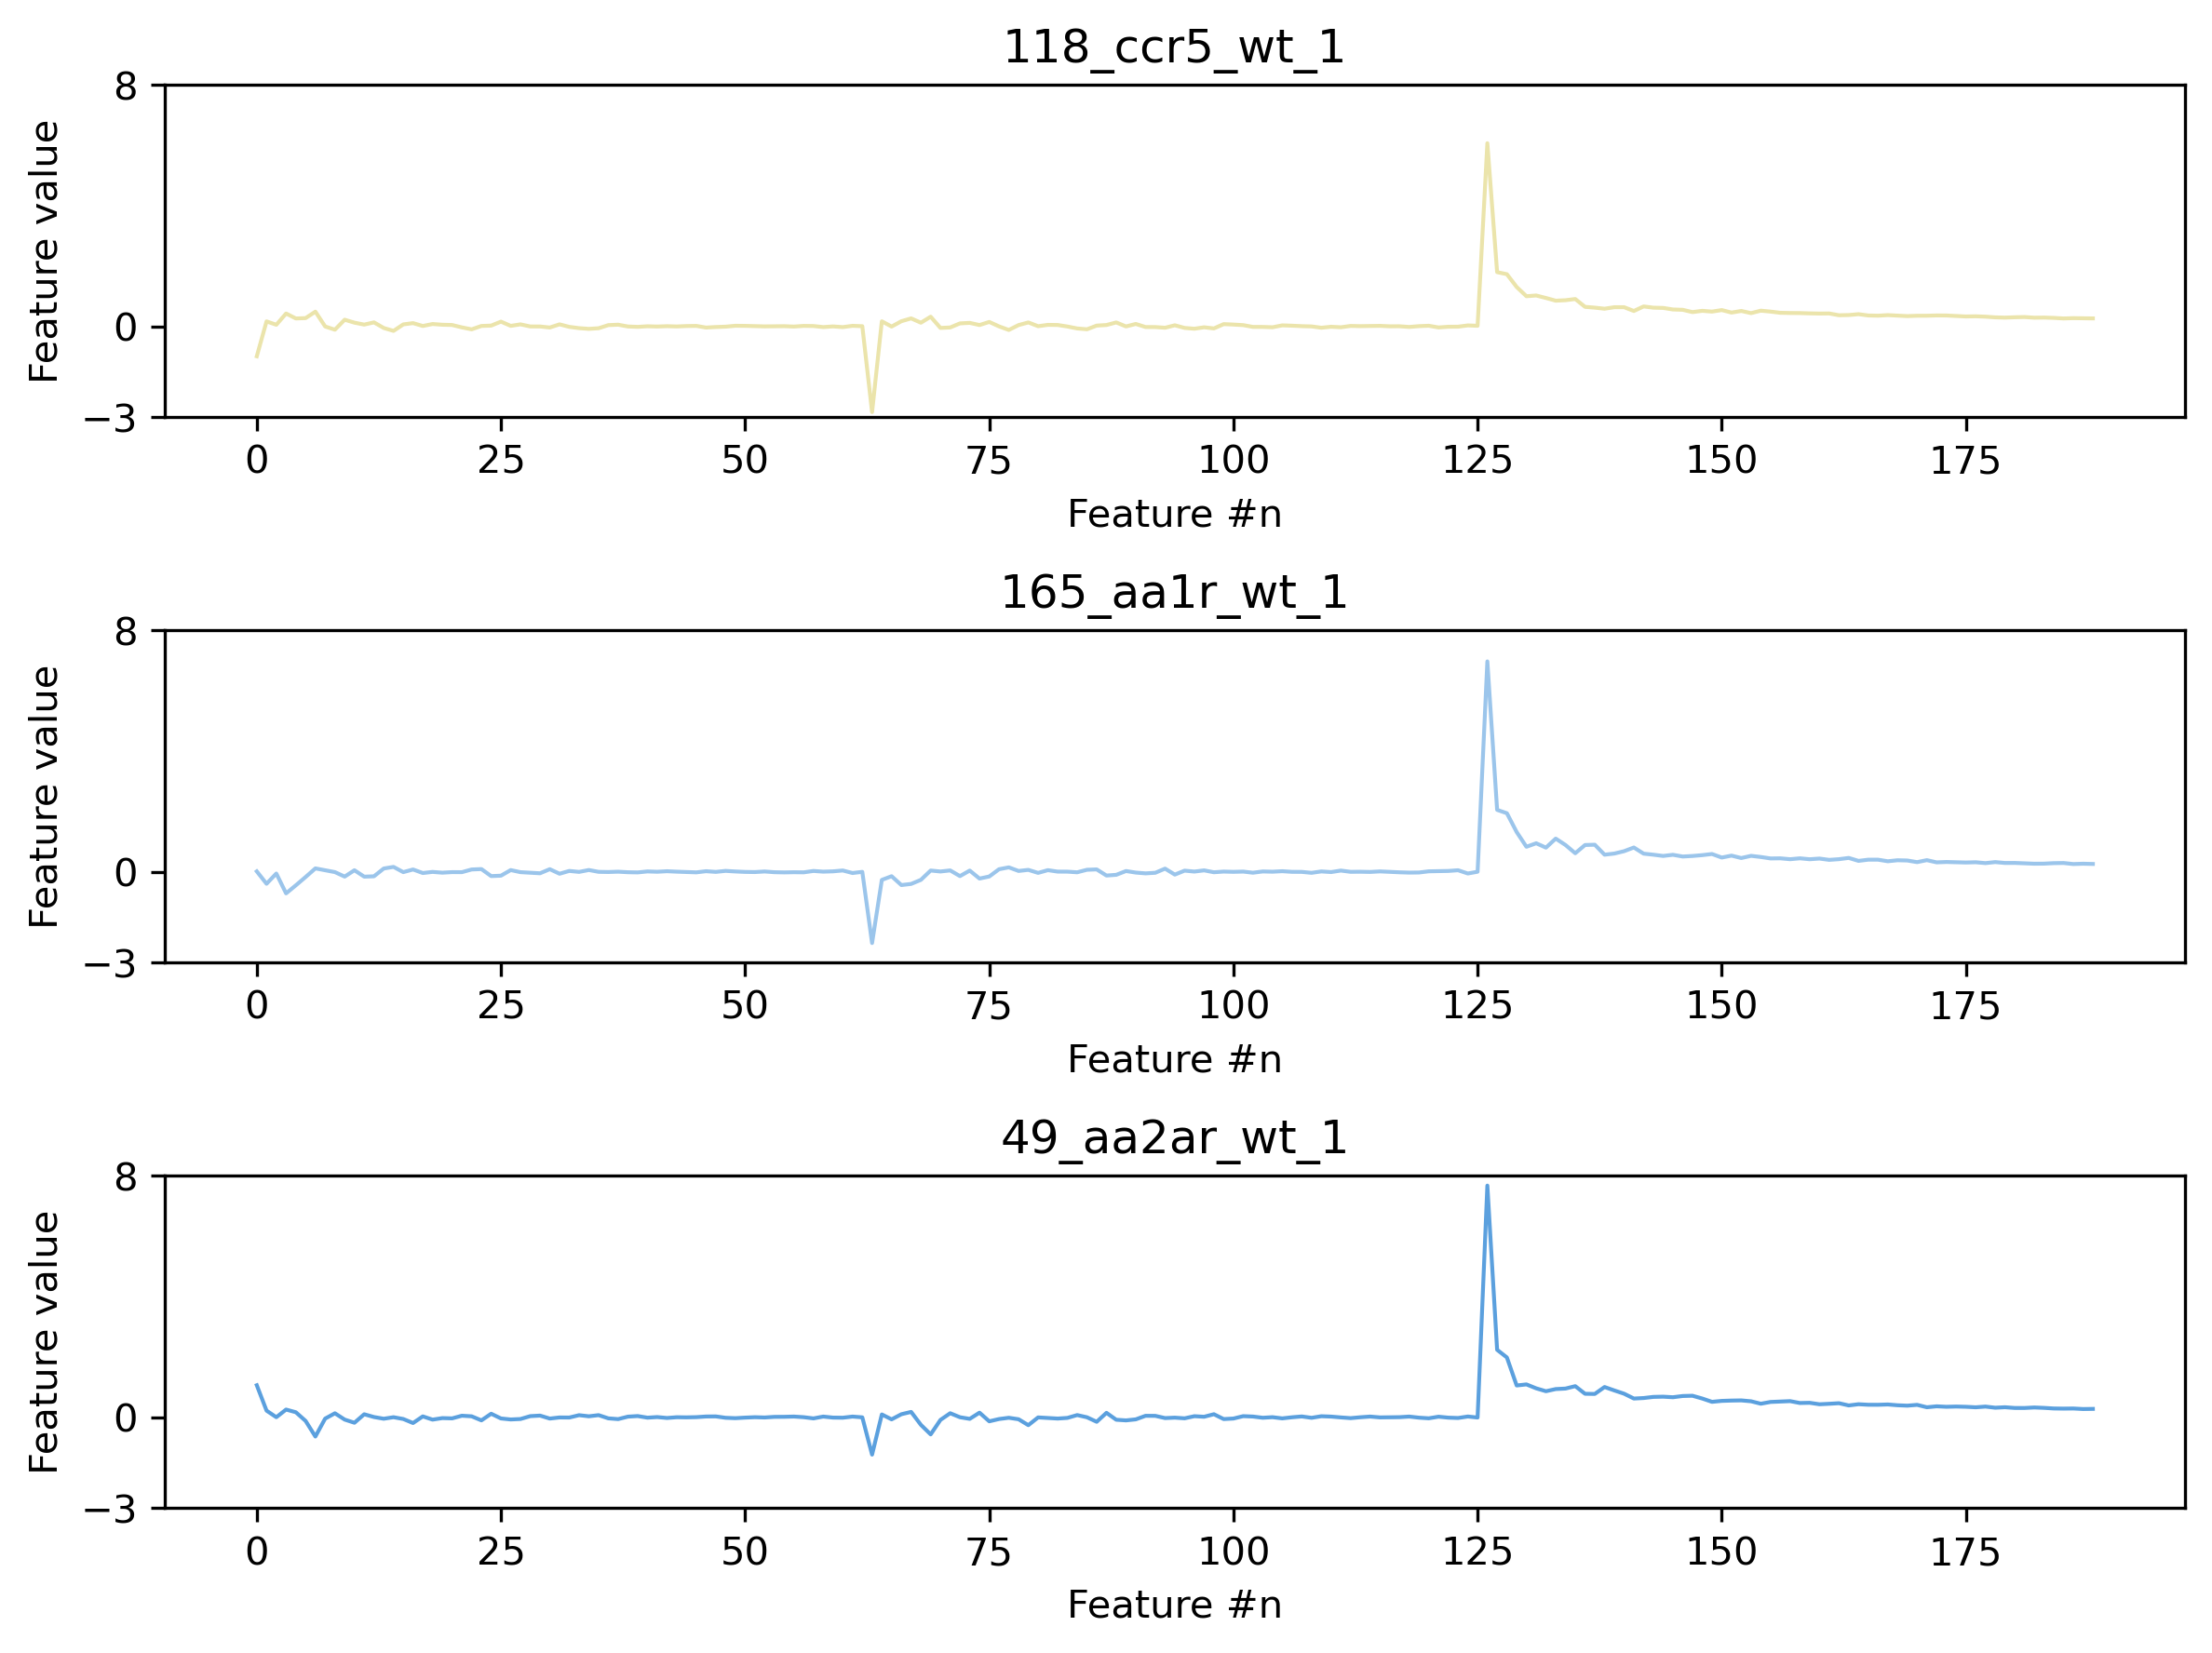

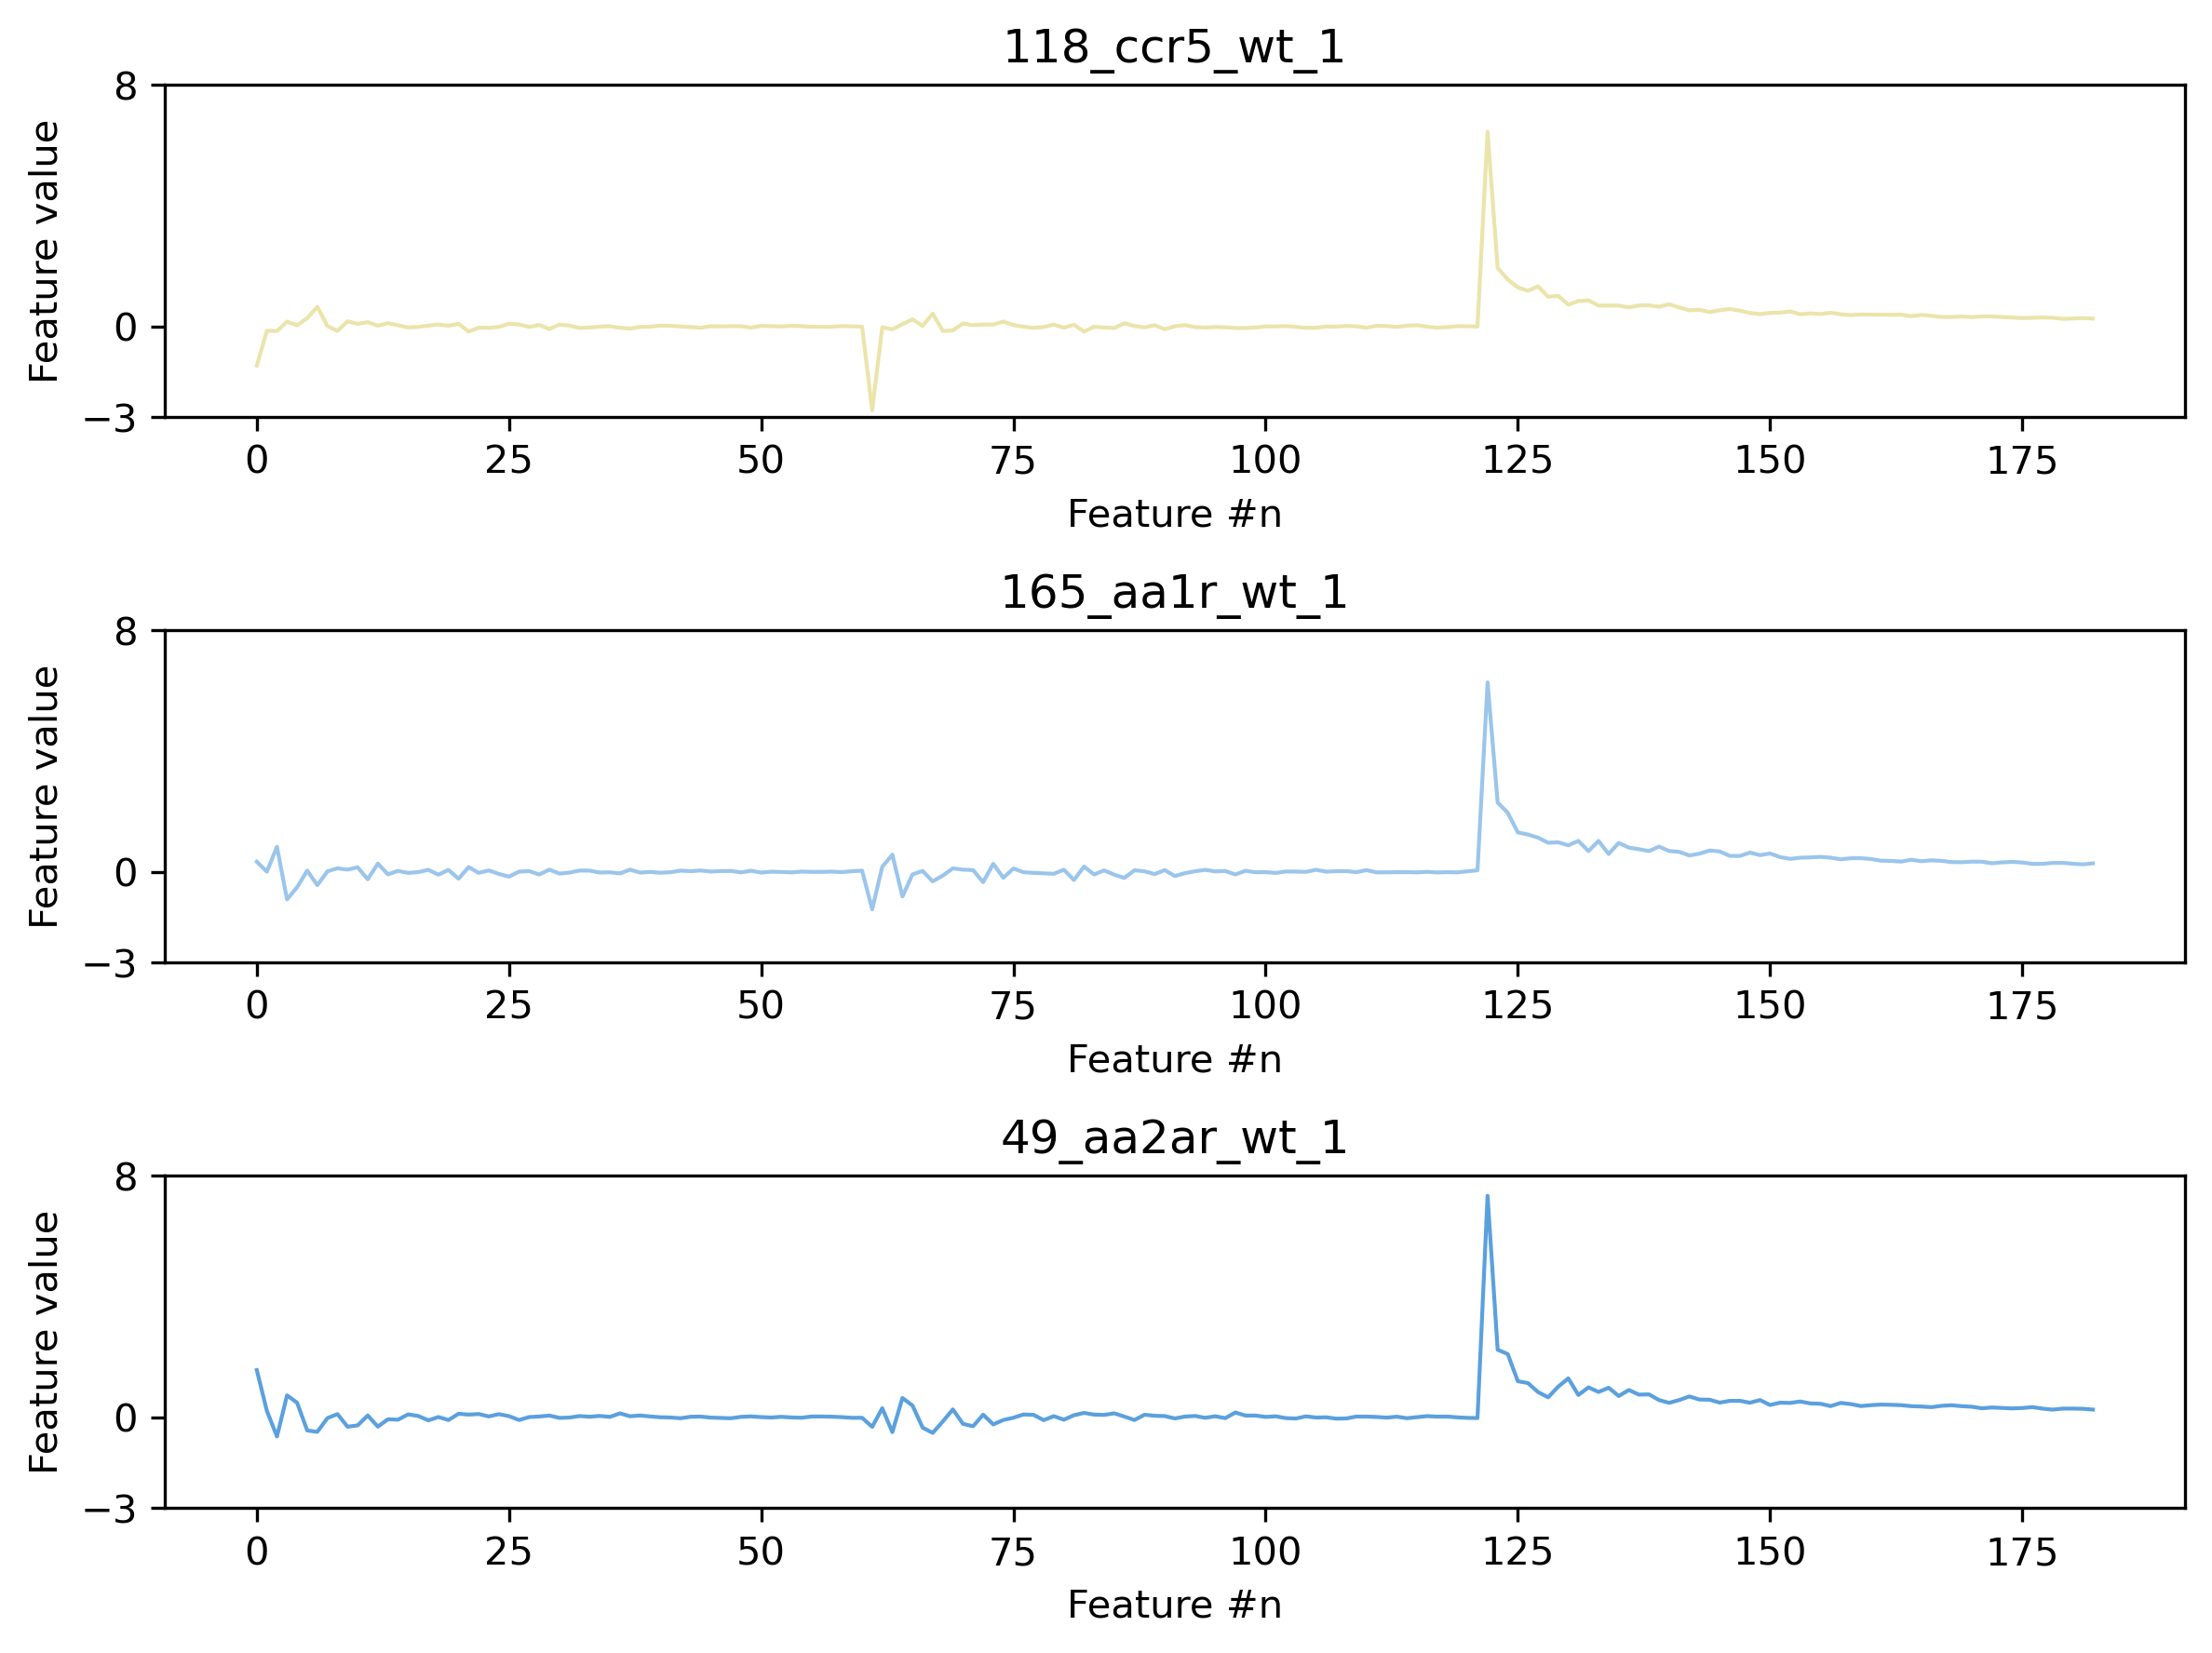

In [13]:
for descriptor_name in ['tutorial_3DDPD_PS_std_f100_pc0.99_ga_aa','tutorial_3DDPD_PS_std_f100_pc0.99_sf_aa']:
    descriptor = DynDescriptor.Descriptor(out_path,descriptor_name,out_path)
    descriptor.plot_all_entries_one_col(subset=None, title_var='entry', save=True)

Indeed we can observe certain differences with the ps3DDPD that uses tthe full sequence and using just residues in different definitions of the binding pocket. However, in general we will still benchmark different possibilities for the dataset of interest for machine elarning applications. 